# Recommender systems

## One of the most common uses of big data is to predict and suggest what users may want.  This allows Google to show you relevant ads or to suggest news in Google Now; Amazon to recommend relevant products; Netflix to recommend movies that you might like; or most recently, the famous **Weekly Dicovery** of Spotify.

## All these products are based on systems of recommendation: a information retrieval method to provide users with relevant, yet novel and diverse, information. 

## In this class we will use a pretty famous dataset based on movies ratings, 'MovieLens', to learn the basics of recommender systems. 

## Table of Contents (times are approximated)

1. [Getting and analysing some data (~1:30 h)](#data)
2. [Most popular movies (~30 min)](#popular)
3. [Metrics for recommender systems (~1.30h)](#metrics)
4. [Collaborative Filtering (~15 min)](#cf)  
   4.1 [Co-occurrence Matrix (~1.30h)](#copurchase)
   <br></br>
   4.2 [Memory-based CF (~1 h)](#memory-base)
   <br></br>
   4.3 [Model-based CF (~2 h)](#model-base)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os

<a id='data'></a>
## 1.1 Load data

We will use MovieLens dataset, which is one of the most common datasets used when implementing and testing recommender engines. This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens [website](https://movielens.org) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set.

You can download the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip).

Take a look at the readme file!!!

In [2]:
data_root = "ml-100k/"
readme = os.path.join(data_root, "README")
!cat $readme

"cat" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [3]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
datafile = os.path.join(data_root, "u.data")
data = pd.read_csv(datafile, sep='\t', names=columns)
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
data.values[:, :3]

array([[ 196,  242,    3],
       [ 186,  302,    3],
       [  22,  377,    1],
       ..., 
       [ 276, 1090,    1],
       [  13,  225,    2],
       [  12,  203,    3]], dtype=int64)

In [5]:
data.values.shape

(100000, 4)

In [6]:
data.user_id.unique().shape

(943,)

In [7]:
n_users = data.user_id.unique().shape[0]
n_items = data.item_id.unique().shape[0]
print("There are %s users and %s items" %(n_users, n_items))

There are 943 users and 1682 items


In [8]:
data.values[:20]

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116],
       [      244,        51,         2, 880606923],
       [      166,       346,         1, 886397596],
       [      298,       474,         4, 884182806],
       [      115,       265,         2, 881171488],
       [      253,       465,         5, 891628467],
       [      305,       451,         3, 886324817],
       [        6,        86,         3, 883603013],
       [       62,       257,         2, 879372434],
       [      286,      1014,         5, 879781125],
       [      200,       222,         5, 876042340],
       [      210,        40,         3, 891035994],
       [      224,        29,         3, 888104457],
       [      303,       785,         3, 879485318],
       [      122,       387,         5, 879270459],
       [      194,       274,         2, 879539794],
       [      291,      1042,         4, 87483

## 1.2 A dictionary for movies and a search tool

In order to analyze the predicted recommendations, let's create a python dictonary that will allow us to translate any item id to the corresponding movie title. Also, let's write a small function that returns the ids of the movies containing some text.

The correspondance between titles and ids is stored in the u.item file

In [9]:
data_root = "ml-100k/"
items_id_file = os.path.join(data_root, "u.item")
!head $items_id_file

"head" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [10]:
# Create a dictionary for movie titles and ids
item_dict = {}
with io.open(items_id_file, 'rb') as f:
    for line in f.readlines():
        record = line.split(b'|')
        item_dict[int(record[0])] = str(record[1])
    
# We can use this dict to see the films a user has seen, for instance. 
for record in data.values[:20]:
    print("User {u} viewed '{m}' and gave a {r} rating".format(
        u=record[0], m=item_dict[record[1]], r=record[2]))    

User 196 viewed 'b'Kolya (1996)'' and gave a 3 rating
User 186 viewed 'b'L.A. Confidential (1997)'' and gave a 3 rating
User 22 viewed 'b'Heavyweights (1994)'' and gave a 1 rating
User 244 viewed 'b'Legends of the Fall (1994)'' and gave a 2 rating
User 166 viewed 'b'Jackie Brown (1997)'' and gave a 1 rating
User 298 viewed 'b'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'' and gave a 4 rating
User 115 viewed 'b'Hunt for Red October, The (1990)'' and gave a 2 rating
User 253 viewed 'b'Jungle Book, The (1994)'' and gave a 5 rating
User 305 viewed 'b'Grease (1978)'' and gave a 3 rating
User 6 viewed 'b'Remains of the Day, The (1993)'' and gave a 3 rating
User 62 viewed 'b'Men in Black (1997)'' and gave a 2 rating
User 286 viewed 'b"Romy and Michele's High School Reunion (1997)"' and gave a 5 rating
User 200 viewed 'b'Star Trek: First Contact (1996)'' and gave a 5 rating
User 210 viewed 'b'To Wong Foo, Thanks for Everything! Julie Newmar (1995)'' and gave a 3 

In [11]:
aux = {'hola': 'que haces?', 1: '237'}

In [12]:
aux['hola']

'que haces?'

In [13]:
item_dict

{1: "b'Toy Story (1995)'",
 2: "b'GoldenEye (1995)'",
 3: "b'Four Rooms (1995)'",
 4: "b'Get Shorty (1995)'",
 5: "b'Copycat (1995)'",
 6: "b'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)'",
 7: "b'Twelve Monkeys (1995)'",
 8: "b'Babe (1995)'",
 9: "b'Dead Man Walking (1995)'",
 10: "b'Richard III (1995)'",
 11: "b'Seven (Se7en) (1995)'",
 12: "b'Usual Suspects, The (1995)'",
 13: "b'Mighty Aphrodite (1995)'",
 14: "b'Postino, Il (1994)'",
 15: 'b"Mr. Holland\'s Opus (1995)"',
 16: "b'French Twist (Gazon maudit) (1995)'",
 17: "b'From Dusk Till Dawn (1996)'",
 18: "b'White Balloon, The (1995)'",
 19: 'b"Antonia\'s Line (1995)"',
 20: "b'Angels and Insects (1995)'",
 21: "b'Muppet Treasure Island (1996)'",
 22: "b'Braveheart (1995)'",
 23: "b'Taxi Driver (1976)'",
 24: "b'Rumble in the Bronx (1995)'",
 25: "b'Birdcage, The (1996)'",
 26: "b'Brothers McMullen, The (1995)'",
 27: "b'Bad Boys (1995)'",
 28: "b'Apollo 13 (1995)'",
 29: "b'Batman Forever (1995)'",
 30: "b'Belle de jou

In [14]:
# Define a function that retrieves all the ids and titles for movies containing 'text' in its title
def returnItemId(text, ids):
    """
    :param text: string to be looked for in movies titles
    :param ids: dicttionary of {id:title}
    
    :return: a list of (id,title) if text found in titles, and an empty list otherwise.
    """
    search = [(k, v.lower().find(text.lower())) 
              for k,v in list(ids.items())]
    index = [k for k,v in search if v>-1]
    
    return list(zip(index, [ids[i] for i in index])) if len(index)>0 else []

In [15]:
returnItemId('but', item_dict)

[(240, "b'Beavis and Butt-head Do America (1996)'"),
 (435, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (580,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1401, "b'M. Butterfly (1993)'"),
 (1459, "b'Madame Butterfly (1995)'"),
 (1614, "b'Reluctant Debutante, The (1958)'"),
 (1621, "b'Butterfly Kiss (1995)'"),
 (1645, "b'Butcher Boy, The (1998)'"),
 (1650, "b'Butcher Boy, The (1998)'")]

## 1.3 Data consistency (always double check everything!!!)

In [16]:
# check whether titles are unique or not
print(len(set(item_dict.keys())))
print(len(set(item_dict.values())))

1682
1664


### One work around: create another dict that consolidates ids with the same movie title

In [17]:
list(item_dict.items())

[(1, "b'Toy Story (1995)'"),
 (2, "b'GoldenEye (1995)'"),
 (3, "b'Four Rooms (1995)'"),
 (4, "b'Get Shorty (1995)'"),
 (5, "b'Copycat (1995)'"),
 (6, "b'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)'"),
 (7, "b'Twelve Monkeys (1995)'"),
 (8, "b'Babe (1995)'"),
 (9, "b'Dead Man Walking (1995)'"),
 (10, "b'Richard III (1995)'"),
 (11, "b'Seven (Se7en) (1995)'"),
 (12, "b'Usual Suspects, The (1995)'"),
 (13, "b'Mighty Aphrodite (1995)'"),
 (14, "b'Postino, Il (1994)'"),
 (15, 'b"Mr. Holland\'s Opus (1995)"'),
 (16, "b'French Twist (Gazon maudit) (1995)'"),
 (17, "b'From Dusk Till Dawn (1996)'"),
 (18, "b'White Balloon, The (1995)'"),
 (19, 'b"Antonia\'s Line (1995)"'),
 (20, "b'Angels and Insects (1995)'"),
 (21, "b'Muppet Treasure Island (1996)'"),
 (22, "b'Braveheart (1995)'"),
 (23, "b'Taxi Driver (1976)'"),
 (24, "b'Rumble in the Bronx (1995)'"),
 (25, "b'Birdcage, The (1996)'"),
 (26, "b'Brothers McMullen, The (1995)'"),
 (27, "b'Bad Boys (1995)'"),
 (28, "b'Apollo 13 (1995)'"

In [18]:
duplicates_item_dict = {}
# Las claves en "duplicates_item_dict" son los nombres de las películas
# Los valores son una lista de los ids (que pueden ser uno solo, o varios)
for id,name in list(item_dict.items()):
    if name not in duplicates_item_dict:
        duplicates_item_dict[name] = [id]
    else:
        duplicates_item_dict[name] = duplicates_item_dict[name]+[id]

# show hte duplicated titles
for k,v in list(duplicates_item_dict.items()):
    if len(v)>1:
        print(k,v)

b'Chasing Amy (1997)' [246, 268]
b'Kull the Conqueror (1997)' [266, 680]
b"Ulee's Gold (1997)" [297, 303]
b'Fly Away Home (1996)' [304, 500]
b'Ice Storm, The (1997)' [305, 865]
b'Deceiver (1997)' [309, 1606]
b'Desperate Measures (1998)' [329, 348]
b'Body Snatchers (1993)' [573, 670]
b'Substance of Fire, The (1996)' [711, 1658]
b'Money Talks (1997)' [876, 881]
b'That Darn Cat! (1997)' [878, 1003]
b'Hugo Pool (1997)' [1175, 1617]
b'Chairman of the Board (1998)' [1234, 1654]
b'Designated Mourner, The (1997)' [1256, 1257]
b'Hurricane Streets (1998)' [1395, 1607]
b'Sliding Doors (1998)' [1429, 1680]
b'Nightwatch (1997)' [1477, 1625]
b'Butcher Boy, The (1998)' [1645, 1650]


Create a dict where the key are the original ids, and the values are the unique one. 
We will use this dictionary to remove duplicates in a dataframe.

In [19]:
unique_id_item_dict ={}
for index, lista_id in enumerate(duplicates_item_dict.values()) :
    for key in lista_id:
        unique_id_item_dict[key] = index

Create another dict mapping moving titles to this new unique id

In [20]:
unique_item_dict = {unique_id_item_dict[k]:v 
                    for k,v in item_dict.items()}
assert(len(set(unique_item_dict.keys())) == 
       len(set(unique_item_dict.values())))

Now we can use our `returnItemId()` mehtod safely =)

In [21]:
returnItemId('but', unique_item_dict)

[(239, "b'Beavis and Butt-head Do America (1996)'"),
 (431, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (575,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1390, "b'M. Butterfly (1993)'"),
 (1448, "b'Madame Butterfly (1995)'"),
 (1601, "b'Reluctant Debutante, The (1958)'"),
 (1607, "b'Butterfly Kiss (1995)'"),
 (1630, "b'Butcher Boy, The (1998)'")]

In [22]:
returnItemId('but', item_dict)

[(240, "b'Beavis and Butt-head Do America (1996)'"),
 (435, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (580,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1401, "b'M. Butterfly (1993)'"),
 (1459, "b'Madame Butterfly (1995)'"),
 (1614, "b'Reluctant Debutante, The (1958)'"),
 (1621, "b'Butterfly Kiss (1995)'"),
 (1645, "b'Butcher Boy, The (1998)'"),
 (1650, "b'Butcher Boy, The (1998)'")]

## 1.4 Train and test sets

GroupLens provides several splits of the dataset, so that we can check the goodness of our algorithms. See the README file for more  details. Here we will use one of such splits.

Please notice that we have to correct for the non-unique movie's id issue!!

In [23]:
!ls $data_root

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [24]:
trainfile = os.path.join(data_root, 'ua.base')
!head $trainfile

"head" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [25]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
trainfile = os.path.join(data_root, "ua.base")
train = pd.read_csv(trainfile, sep='\t', names=columns)
print('There are %s users, %s itmes and %s pairs in the train set' \
      %(train.user_id.unique().shape[0], train.item_id.unique().shape[0], train.shape[0]))
train.head()


There are 943 users, 1680 itmes and 90570 pairs in the train set


,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [26]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
testfile = os.path.join(data_root, "ua.test")
test = pd.read_csv(testfile, sep='\t', names=columns)
print('There are %s users, %s itmes and %s pairs in the test set' \
      %(test.user_id.unique().shape[0], test.item_id.unique().shape[0], test.shape[0]))
test.head()


There are 943 users, 1129 itmes and 9430 pairs in the test set


,user_id,item_id,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


### Correcting for non-unique movies id 

In [27]:
def func(x):
    return unique_id_item_dict[x]

In [28]:
test['item_id'].apply(lambda z: func(z))

0         19
1         32
2         60
3        116
4        154
5        159
6        170
7        188
8        201
9        264
10        12
11        49
12       250
13       278
14       279
15       288
16       290
17       295
18       309
19       311
20       244
21       292
22       320
23       325
24       328
25       329
26       331
27       332
28       334
29       340
        ... 
9400       6
9401      14
9402     116
9403     123
9404     146
9405     180
9406     256
9407     257
9408     471
9409     984
9410     116
9411     199
9412     260
9413     320
9414     419
9415     423
9416     483
9417     579
9418     599
9419     610
9420      10
9421      57
9422     110
9423     185
9424     214
9425     231
9426     352
9427     565
9428     801
9429    1057
Name: item_id, Length: 9430, dtype: int64

In [29]:
train['item_id'] = train['item_id'].apply(
    lambda pepito: unique_id_item_dict[pepito])
print('Now there are %s unique items in traint set' 
      % train.item_id.unique().shape[0])

Now there are 1662 unique items in traint set


In [30]:
test['item_id'] = test['item_id'].apply(func)
print('Now there are %s unique items in test set' 
      % test.item_id.unique().shape[0])

Now there are 1119 unique items in test set


<a id='popular'></a>
## 2. Most popular movies

Recommending popular items is a simple, yet quite effective baseline for recommendation. Indeed, most RS suffer from a strong *popularity bias*, i.e. they tend to recommend popular items more frequently than they should -just because suggesting what is popular is effective!-. There is a lot of research  devote to understand this behaviour and to develop recipies to avoid it. 

Movies can be ranked according to different popularity metrics:
* Most rated movie (it is assumed that this is the most watched movie)
* Most positively rated movie (rating > 4.0)
* Highest rated movie

## 2.1 Most rated movie

In [31]:
# group the train dataset by item and count the number of users using Pandas
mostRated = train.groupby('item_id')['user_id'].count()

In [32]:
mostRated

item_id
0       392
1       121
2        85
3       198
4        79
5        23
6       346
7       194
8       268
9        82
10      217
11      251
12      164
13      161
14      255
15       36
16       85
17       10
18       60
19       61
20       79
21      280
22      166
23      159
24      251
25       67
26       52
27      249
28      111
29       36
       ... 
1633      1
1634      1
1635      1
1636      3
1638      1
1639      1
1640      1
1641      1
1642      1
1643      1
1644      1
1645      1
1646      3
1647      1
1648      1
1649      1
1650      1
1651      1
1652      1
1653      1
1654      2
1655      1
1656      1
1657      1
1658      1
1659      1
1660      1
1661      1
1662      1
1663      1
Name: user_id, Length: 1662, dtype: int64

In [33]:
# sort in descending order
mostRatedSorted = mostRated.sort_values(ascending=False)

In [34]:
mostRatedSorted

item_id
49      495
99      443
180     439
257     412
284     400
292     398
0       392
286     386
120     384
173     379
126     352
97      350
55      348
298     347
6       346
236     335
171     330
245     322
221     322
116     320
78      311
203     311
209     308
401     303
172     300
150     293
68      292
167     292
194     282
21      280
       ... 
1496      1
1582      1
1329      1
1584      1
1585      1
1328      1
1588      1
1318      1
1590      1
1314      1
1592      1
1338      1
1573      1
1572      1
1561      1
1555      1
1556      1
1557      1
1558      1
1559      1
1560      1
1563      1
1570      1
1564      1
1565      1
1566      1
1341      1
1568      1
1569      1
1663      1
Name: user_id, Length: 1662, dtype: int64

In [35]:
# Return a numpy array of np.array([id, title, frequency])
mostRatedMovies = np.array(
    [np.array([row, unique_item_dict[row], 
               mostRatedSorted[row]], dtype=np.object)
     for row in mostRatedSorted.index])
mostRatedMovies[:10,1:]

array([["b'Star Wars (1977)'", 495],
       ["b'Fargo (1996)'", 443],
       ["b'Return of the Jedi (1983)'", 439],
       ["b'Contact (1997)'", 412],
       ["b'English Patient, The (1996)'", 400],
       ["b'Liar Liar (1997)'", 398],
       ["b'Toy Story (1995)'", 392],
       ["b'Scream (1996)'", 386],
       ["b'Independence Day (ID4) (1996)'", 384],
       ["b'Raiders of the Lost Ark (1981)'", 379]], dtype=object)

## 2.2 Most positively rated movie

In [36]:
# filter movies rated with rating >=4.0. Then group by item, count the number of users and sort in descending order.
positiveRated = train[train.rating>=4.0].groupby('item_id')['user_id'].count().sort_values(ascending=False)

In [37]:
# Return a numpy array of np.array([id, title, frequency])
positiveRatedMovies = np.array(
    [np.array([row, unique_item_dict[row], 
               positiveRated[row]], dtype=np.object)
     for row in positiveRated.index])
positiveRatedMovies[:10,1:]

array([["b'Star Wars (1977)'", 428],
       ["b'Fargo (1996)'", 354],
       ["b'Return of the Jedi (1983)'", 331],
       ["b'Raiders of the Lost Ark (1981)'", 316],
       ["b'Silence of the Lambs, The (1991)'", 310],
       ["b'Godfather, The (1972)'", 298],
       ["b'Contact (1997)'", 276],
       ["b'Toy Story (1995)'", 275],
       ["b'Empire Strikes Back, The (1980)'", 264],
       ["b'Pulp Fiction (1994)'", 262]], dtype=object)

## 2.3 Highest mean rating movie

In [38]:
# obtaine the highest rated movies, with a minium number of users/ratings.
min_ratings = 50

# group the ratings by item and stack them in a list
listRatedMovies = train.groupby('item_id')['rating'].apply(list).reset_index()

# filter movies with a minimum number of ratings
filteredListRatedMovies = listRatedMovies[listRatedMovies.rating.apply(lambda x: len(x)>min_ratings)]

In [39]:
filteredListRatedMovies.head()

,item_id,rating
0,0,"[5, 4, 4, 4, 3, 1, 5, 5, 3, 5, 5, 5, 3, 5, 4, ..."
1,1,"[3, 3, 2, 3, 5, 1, 3, 3, 4, 4, 3, 2, 2, 3, 4, ..."
2,2,"[4, 2, 3, 4, 3, 2, 2, 1, 3, 3, 5, 3, 3, 3, 2, ..."
3,3,"[3, 5, 4, 5, 5, 5, 3, 5, 4, 2, 4, 4, 3, 3, 2, ..."
4,4,"[3, 1, 2, 3, 4, 4, 4, 3, 3, 2, 4, 3, 3, 4, 3, ..."


In [40]:
# obtain the mean of the list of rating per movie
meanMovies = filteredListRatedMovies.rating.apply(lambda x: np.mean(np.array(x))).sort_values(ascending=False)

In [41]:
# Return a numpy array of np.array([id, title, frequency])
meanRateMovies = np.array([np.array([i, unique_item_dict[i], meanMovies[i]], dtype=np.object) 
                          for i in meanMovies.index])

meanRateMovies[:10,1:]

array([["b'Wallace & Gromit: The Best of Aardman Animation (1996)'",
        4.4915254237288131],
       ["b'Close Shave, A (1995)'", 4.4807692307692308],
       ["b'Wrong Trousers, The (1993)'", 4.4766355140186915],
       ['b"Schindler\'s List (1993)"', 4.4758364312267656],
       ["b'Casablanca (1942)'", 4.4598214285714288],
       ["b'Shawshank Redemption, The (1994)'", 4.4573643410852712],
       ["b'Usual Suspects, The (1995)'", 4.3864541832669319],
       ["b'Rear Window (1954)'", 4.3743589743589739],
       ["b'Star Wars (1977)'", 4.3656565656565656],
       ["b'12 Angry Men (1957)'", 4.3274336283185839]], dtype=object)

<div class  = "alert alert-info"> 
** QUESTION **: set the value of *min_ratings* to 1, and re-run the cell. What happens now? Change this value
</div>

<div class  = "alert alert-info"> 
** QUESTION **: Which method is better?? How to measure a recommender system? 
</div>

<div class  = "alert alert-info"> 
** IMPORTANT QUESTION **: When might be useful to recommend popular items?
</div>

<a id='metrics'></a>
## 3. Metrics for recommender systems

As we have seen, even with the simplest solution --aka, recommending popular items-- is difficult to known which technique performs better. For this, there are a number of metrics that allow one to measure the goodness of a recommender system. 

Metrics can be design for measuring the relevance or accuracy of a recommendation, but they can be created for evaluating the novelty of a recommendation, or its diversity. 

For now, we will focus on relevance and accuracy. Several metrics exist:
* Accuracy: rmse, mae.
* Not ranked: Recall@k, Precision@k.
* With rank disccount: map@k, ndcg@k.
* With rank ordering: mean percentile rank.

We will be definiing some of them whitin this class. For the moment, let's talk about precision and recall.

## 3.1 Precision and recall

<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" alt="Precision and Recall in IR" style="float: right; width: 300px"/>

The concept of precision and recall comes form the world of information retrieval, have a look at the wikipedia:

https://en.wikipedia.org/wiki/Precision_and_recall

From this entry:

 * "**precision** (also called positive predictive value) is the fraction of retrieved instances that are relevant".
 * "**recall** (also known as sensitivity) is the fraction of relevant instances that are retrieved".

<br />
<div class  = "alert alert-info"> 
** QUESTION **: how do we know if some movie, unknown to the user, is relevant?
</div>

In other words, we cannot measure a false positive --something recommended that was not relevant--. In this regard, only recall-oriented metrics have an actual meaning in RS. Nonetheless, its common practice to define both metrics in RS as follows:
 
### $$\mathrm{recall}@N = \frac{\sum_{k=1}^N rel(k)}{\sum_{i\in \mathcal{I}_u} 1}$$
### $$\mathrm{precision}@N = \frac{\sum_{k=1}^N rel(k)}{N}$$

Here, $\mathcal{I}_u$ is the set of items adopted by user $u$, and $rel(k)$ is the relevance of a recommendation at position k in the list of recommendations. For ratings, the relevance could be defined as those movies rated above a certain threshold, e.g. $r_{ui}>4.0$. 

**Important to note: since precision is pretty much the same as recall in RS, metrcis usch as the *area under the ROC curve* doesn't have any meaning!!**

<div class = "alert alert-success">
As an example, consider a user that watched the following films:
<br /><br />
'Designated Mourner, The (1997)'
<br />
'Money Talks (1997)'
<br />
'Madame Butterfly (1995)'
<br />
'Batman Forever (1995)'
<br /><br />
The recommended items were: 
<br /><br />
'Batman (1989)' 
<br />
'Madame Butterfly (1995)'
<br /><br />
**What would be the recall and precision @1? and @2?**
<br />
**What do you think of recommending Batman? Is a bad or a good recommendation?**
</div>

Please notice that there isn't any actual difference between precision and recall in the context of RS: both measure the relevance of the recommendations, and tell nothing about items recommended that haven't been adopted by the user. Thus, it make sense to define a normalized recall as:

### $$\mathrm{recall}@N = \frac{\sum_{i=1}^N rel_i}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1})$$

This way, results are normalized to 1 always.

<div class="alert alert-success">
**Exercise** Implement the above definition of recall
</div>

In [42]:
def recall_at_n(N, test, recommended, train=None):
    """
    :param N: number of recommendations
    :param test: list of movies seen by user in test
    :param train: list of movies seen by user in train. This has to be removed from the recommended list 
    :param recommended: list of movies recommended
    
    :return the recall
    """
    if train is not None: 
        # Esto estaría mal!!! por qué?
        # rec_true =  set(recommended)- set(train)
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended    
    intersection = len(set(test) & set(rec_true[:N]))
    return intersection / float(np.minimum(N, len(test)))

In [43]:
seen = ['Designated Mourner, The (1997)', 'Money Talks (1997)', 'Madame Butterfly (1995)', 'Batman Forever (1995)']
recommended = ['Batman (1989)', 'Madame Butterfly (1995)']

In [44]:
recall_at_n(1, seen, recommended)

0.0

In [45]:
recall_at_n(2, seen, recommended)

0.5

In [46]:
# Check it's well normalized
print(recall_at_n(3, seen, recommended))
print(recall_at_n(10, seen, recommended))
print(recall_at_n(100, seen, recommended))

0.3333333333333333
0.25
0.25


### Now, use this implementation to measure the efficiency of the popularity baselines in the test set. Use the top-5 movies, for instance

In [47]:
mostRatedMovies[:5,1:]

array([["b'Star Wars (1977)'", 495],
       ["b'Fargo (1996)'", 443],
       ["b'Return of the Jedi (1983)'", 439],
       ["b'Contact (1997)'", 412],
       ["b'English Patient, The (1996)'", 400]], dtype=object)

In [48]:
positiveRatedMovies[:5,1:]

array([["b'Star Wars (1977)'", 428],
       ["b'Fargo (1996)'", 354],
       ["b'Return of the Jedi (1983)'", 331],
       ["b'Raiders of the Lost Ark (1981)'", 316],
       ["b'Silence of the Lambs, The (1991)'", 310]], dtype=object)

In [49]:
meanRateMovies[:5,1:]

array([["b'Wallace & Gromit: The Best of Aardman Animation (1996)'",
        4.4915254237288131],
       ["b'Close Shave, A (1995)'", 4.4807692307692308],
       ["b'Wrong Trousers, The (1993)'", 4.4766355140186915],
       ['b"Schindler\'s List (1993)"', 4.4758364312267656],
       ["b'Casablanca (1942)'", 4.4598214285714288]], dtype=object)

In [50]:
# get movies in train and test, and join them
trainUsersGrouped = (train[train.rating>=4.0]
                    .groupby('user_id')['item_id']
                    .apply(list).reset_index()
                   )

testUsersGrouped = (test[test.rating>=4.0]
                    .groupby('user_id')['item_id']
                    .apply(list).reset_index()
                   )
joined = pd.merge(trainUsersGrouped, testUsersGrouped, how='inner', on='user_id')

In [51]:
joined.head()

,user_id,item_id_x,item_id_y
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21...","[19, 32, 60, 159, 170, 201, 264]"
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ...","[12, 49, 250, 290, 295]"
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ...","[325, 328]"
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3...","[49, 259, 286, 292, 295, 350, 353, 357]"
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ...","[0, 16]"


In [52]:
# we can access test values as follows:
joined.apply(lambda x: x[2], axis=1).head()

0           [19, 32, 60, 159, 170, 201, 264]
1                    [12, 49, 250, 290, 295]
2                                 [325, 328]
3    [49, 259, 286, 292, 295, 350, 353, 357]
4                                    [0, 16]
dtype: object

In [53]:
topN = 30
# calculate the average recall across all users
joined.apply(lambda l: 
             recall_at_n(topN, l[2], mostRatedMovies[:, 0], l[1]), axis=1).mean()

0.23399655008327372

In [54]:
joined.apply(lambda l: 
             recall_at_n(topN, l[2], positiveRatedMovies[:, 0], l[1]), axis=1).mean()

0.23440569661126404

In [55]:
joined.apply(lambda l: 
             recall_at_n(topN, l[2], meanRateMovies[:, 0], l[1]), axis=1).mean()

0.13298239352843227

## 3.2 Mean Averaged Precision (MAP)

Previous metrics did not account for the ranking of the recommendation, i.e. the relative position of a movie within the sorted list of recommendations. **But orders matters!** Metrics like MAP, MRR or NDCG try to tackle down this problem. 

From the blog *http://fastml.com/what-you-wanted-to-know-about-mean-average-precision/*:

> Here’s another way to understand average precision. Wikipedia says AP is used to score document retrieval. You can think of it this way: you type something in Google and it shows you 10 results. It’s probably best if all of them were relevant. If only some are relevant, say five of them, then it’s much better if the relevant ones are shown first. It would be bad if first five were irrelevant and good ones only started from sixth, wouldn’t it? AP score reflects this.

Implementation taken from:

https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py



## Average Precision 

The Average Precision is definied as:

### $$\mathrm{AP}@N = \frac{\sum_{k=1}^N P(k) \times rel(k)}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1)}$$

where $P(k)$ is the precision at cut-off in the item list, i.e. the ratio of the number of recommended items adopted, up to the position k, over the number k. Thus:

### $$\mathrm{AP}@N = \frac{\sum_{k=1}^N \left(\sum_{i=1}^k rel(i)\right)/k \times rel(k)}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1)}$$



<div class = "alert alert-success">
Following the example above, consider a user that watched the following films:
<br /><br />
'Designated Mourner, The (1997)'
<br />
'Money Talks (1997)'
<br />
'Madame Butterfly (1995)'
<br />
'Batman Forever (1995)'
<br /><br />
The recommended items were: 
<br /><br />
'Batman (1989)' 
<br />
'Madame Butterfly (1995)'
<br /><br />

<div class = "alert alert-success">
**Calculate AP@1**
<br /><br />
First, *rel(1)=0*, because Batman was not viewed. Also, *P(1) = 0*. Thus, AP@1=0.
<br />
**Calculate AP@2**
<br /><br />
As before, *rel(1)=0*, so the first term does not contribute. For the second term, *rel(2)=1*, so that *P(2)=0.5*. The numerator is hence:
<br /><br />
$P(1)*rel(1)+P(2)*rel(2)=0*0+0.5*1$
<br /><br />
For the denominator, $N=2$ and $\sum_{i\in \mathcal{I}_u} 1)=4$, thus:
<br /><br />
AP@2 = 0.5/2 = 0.25
</div>

Let's now implement it =)

In [56]:
def apk(k, test, recommended, train=None):
    """
    Computes the average precision at k.
    
    :param k: number of recommendations
    :param test: list of movies seen by user in test
    :param train: list of movies seen by user in train. This has to be removed from the recommended list 
    :param recommended: list of movies recommended
    
    :return The average precision at k over the test set
    """
    if train is not None: 
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended    
    predicted = rec_true[:k] # top-k predictions
    
    score = 0.0 # This will store the numerator
    num_hits = 0.0 # This will store the sum of rel(i)

    for i,p in enumerate(predicted):
        if p in test and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits/(i+1.0)

    return score / min(len(test), k)

In [57]:
seen = ['Designated Mourner, The (1997)', 'Money Talks (1997)', 'Madame Butterfly (1995)', 'Batman Forever (1995)']
recommended = ['Batman (1989)', 'Madame Butterfly (1995)']

In [58]:
apk(1, seen, recommended)

0.0

In [59]:
apk(2, seen, recommended)

0.25

In [60]:
apk(3, seen, recommended)

0.16666666666666666

## MAP

Mean avergae precision is nothing else than the AP averaged across users ;)

Apply it to popularity baselines

In [187]:
topN = 1
predictions = mostRatedMovies[:, 0]
m1 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m1))
topN = 10
m2 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m2))

map@1=0.18
map@10=0.05


In [62]:
topN = 1
predictions = positiveRatedMovies[:, 0]
m1 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m1))
topN = 10
m2 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m2))

map@1=0.13
map@10=0.05


In [63]:
topN = 1
predictions = meanRateMovies[:, 0]
m1 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m1))
topN = 10
m2 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m2))

map@1=0.01
map@10=0.01


### In case of personalized recommendations, it makes sense to define MAP as follows:

In [64]:
def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


<img src="https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif" alt="collaborative filtering" style="float: right; width: 300px"/>

## 4. Collaborative Filtering <a id='cf'></a>

Perhaps, one of the most succesful techniques for making personalized recommendations are the so called *collaborative filtering* (CF) algorithms. CF is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue X than to have the opinion on X of a person chosen randomly. 

The image at the right (from Wikipedia) shows an example of user's preference prediction using collaborative filtering. At first, people rate different items (like videos, images, games). After that, the system is making predictions about a user's rating for an item, which the user has not rated yet. These predictions are built upon the existing ratings of other users, who have similar ratings with the active user. For instance, in the image at the right the system has made a prediction, that the active user will not like the video.

In this part we will see three kinds of CF, of increasing complexity:

4.1 [CF with co-occurrence](#copurchase)

4.2 [Memory-based CF](#memory-base)

4.3 [Model-based CF](#model-base)

<a id='copurchase'></a>
## 4.1 Co-occurrence Matrix

The idea is to recommend movies similar to the movies already seen by a user. A measurement of similarity among items is obtained from the co-occurrence matrix. This is nothing else than the adjacency matrix of the graph of items created by users!!!

<table border="0" style="width:825px;border:0px;">
<tr>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/Les-Miserables-Co-Occurrence.png" style="width: 500px"/>
    </td>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/midnight-club-graph.png" style="width: 400px"/>
    </td>
</tr>
</table>


In [67]:
# create a dictionary of movies per user
moviesPerUser = (train[train.rating>=4]
                 .groupby('user_id')['item_id']
                 .apply(np.array)
                 .to_dict()
                 )
moviesPerUser

{1: array([  0,   2,   5,   6,   8,  11,  12,  13,  14,  15,  17,  18,  21,
         22,  24,  27,  31,  38,  41,  42,  43,  44,  45,  46,  47,  49,
         50,  51,  54,  55,  56,  57,  58,  59,  63,  64,  65,  67,  71,
         74,  75,  76,  78,  79,  80,  81,  83,  85,  86,  87,  88,  89,
         90,  92,  94,  95,  97,  99, 105, 106, 107, 108, 110, 112, 113,
        114, 118, 120, 122, 123, 126, 127, 128, 131, 132, 133, 134, 136,
        143, 145, 149, 150, 151, 153, 155, 156, 160, 161, 162, 164, 165,
        167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 180, 181, 182,
        183, 184, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 202, 203, 205, 206, 207, 208, 209, 211, 213, 215, 220, 221,
        222, 223, 226, 227, 228, 229, 233, 234, 235, 237, 238, 240, 241,
        245, 247, 248, 249, 250, 252, 255, 256, 257, 266, 245, 267, 268], dtype=int64),
 2: array([  0,  13,  24,  99, 110, 126, 236, 241, 254, 256, 267, 270, 271,
        273, 274, 275, 277, 28

In [68]:
# create a dictionary of movies per user
moviesPerUser = (train[train.rating>=4]
                 .groupby('user_id')['item_id']
                 .apply(np.array)
                 .to_dict()
                 )

# calculate the number of items in train
n_items = len(unique_item_dict.keys())

# co-ocurrance matrix will have shape=[n_items,n_items]
coMatrix = np.zeros((n_items, n_items)) # co-occurrence matrix
for user, movies in moviesPerUser.items():
    for m in movies:
        coMatrix[m, movies] += 1

coMatrix

array([[ 275.,   26.,   17., ...,    0.,    0.,    0.],
       [  26.,   46.,    4., ...,    0.,    0.,    0.],
       [  17.,    4.,   32., ...,    0.,    0.,    0.],
       ..., 
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

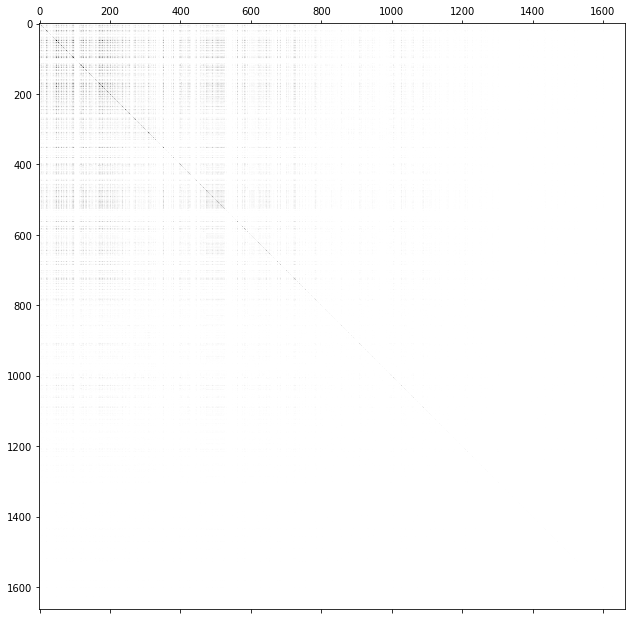

In [69]:
# visualize the matrix
plt.matshow(coMatrix, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

<div class="alert alert-success">
**QUESTION:** Can you think of a better way of visualizaing this matrix? Try to rescale it, or to rearrenge it follwoing some criteria (for instance, popularity!).
</div>

In [70]:
mostRatedMovies

array([[49, "b'Star Wars (1977)'", 495],
       [99, "b'Fargo (1996)'", 443],
       [180, "b'Return of the Jedi (1983)'", 439],
       ..., 
       [1568, "b'Baton Rouge (1988)'", 1],
       [1569, "b'Liebelei (1933)'", 1],
       [1663, "b'Scream of Stone (Schrei aus Stein) (1991)'", 1]], dtype=object)

In [71]:
mostRatedMovies[:, 0].astype(np.int)

array([  49,   99,  180, ..., 1568, 1569, 1663])

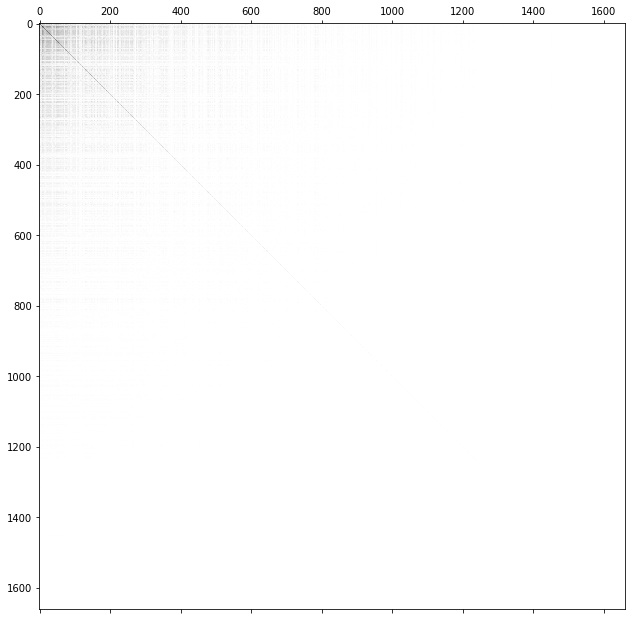

In [72]:
popular_indexing = mostRatedMovies[:, 0].astype(np.int)
coMatrix_sorted = coMatrix[:, popular_indexing]
coMatrix_sorted_total = coMatrix_sorted[popular_indexing, :]
plt.matshow(coMatrix_sorted_total, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


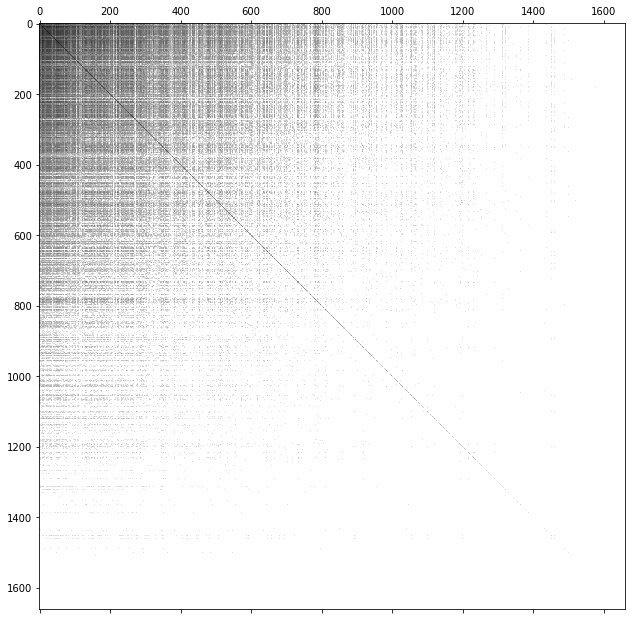

In [73]:
# better plot it in log scale!
plt.matshow(np.log(coMatrix_sorted_total), fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

### 4.1.1 Making predictions using the co-occurrence matrix

This kind of recommendations, based on item similarity, provide a measure of the closeness of one item to another. In order to make a recommendation for a user, we have to proceed as follows:

* First, define a function that returns the top-N closest items to a given one.
* Then, for a list of items adopted by a specific user, select the top-N items from the lists of top-N closest items to each adopted item.

In [74]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Returns the top-N most similar items to a given one, based on the coocurrance matrix
    
    :param item_id: id of input item
    :param cooccurrance: 2-dim numpy array with the co-occurance matrix
    :param ntop: number of items to be retrieved
    
    :return top-N most similar items to the given item_id
    """
    similarItems = coocurrance[item_id, :]
    # return indeces of most similar items in descendign order
    mostSimilar = np.argsort(similarItems)[::-1]
    # remove the first element, as it is the item itslef
    mostSimilar = mostSimilar[1:ntop+1]
    
    # return a numpy array with the index and the value of the most similar items
    return np.stack((mostSimilar, similarItems[mostSimilar]))

In [75]:
a = coMatrix[23, :]
a

array([ 40.,  14.,  14., ...,   0.,   0.,   0.])

In [76]:
b = np.argsort(coMatrix[23, :])
b

array([ 831, 1155, 1163, ...,  171,   49,   23], dtype=int64)

In [77]:
a[b]

array([  0.,   0.,   0., ...,  52.,  61.,  81.])

In [75]:
queryMovieId = 23
Ntop = 5
print('For item "%s" top-%s recommendations are:' % (unique_item_dict[queryMovieId], Ntop))

similarItems = co_occurrance_similarity(queryMovieId, coMatrix, Ntop)
# let's print out the first Ntop recommendations
for r in similarItems:
    print(unique_item_dict[r[0]], r[1])

For item "b'Rumble in the Bronx (1995)'" top-5 recommendations are:
b'Star Wars (1977)' 171.0
b'Stargate (1994)' 52.0


In [91]:
queryMovieId = 23
Ntop = 5
print('For item "%s" top-%s recommendations are:' % (unique_item_dict[queryMovieId], Ntop))

similarItems = co_occurrance_similarity(queryMovieId, coMatrix, Ntop)
# let's print out the first Ntop recommendations
for r in similarItems.T:
    print(unique_item_dict[r[0]], r[1])

For item "b'Rumble in the Bronx (1995)'" top-5 recommendations are:
b'Star Wars (1977)' 61.0
b'Empire Strikes Back, The (1980)' 52.0
b'Fargo (1996)' 52.0
b'Raiders of the Lost Ark (1981)' 52.0
b'Return of the Jedi (1983)' 51.0


In [92]:
queryMovieId = 25
Ntop = 5
print('For item "%s" top-%s recommendations are:' % (unique_item_dict[queryMovieId], Ntop))

similarItems = co_occurrance_similarity(queryMovieId, coMatrix, Ntop)
# let's print out the first Ntop recommendations
for r in similarItems.T:
    print(unique_item_dict[r[0]], r[1])

For item "b'Brothers McMullen, The (1995)'" top-5 recommendations are:
b'When Harry Met Sally... (1989)' 22.0
b'Pulp Fiction (1994)' 21.0
b'Princess Bride, The (1987)' 20.0
b'Usual Suspects, The (1995)' 19.0
b'Jerry Maguire (1996)' 19.0


Now, let use this function to make recommendations:

In [180]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Obtain the list of ntop recommendations based on a list of items (user history of views)
    
    :param items_id: list of items ids
    :param coocurrence: co-ocurrence matrix (numpy 2-dim array)
    :param ntop: top-K items to be retrieved
    
    :return list of ntop items recommended
    """
    # put together all the similar items and its value
    mylist = []
    for n in items_id:
        mylist.append(co_occurrance_similarity(n, coMatrix, 50).T) 
        # Aquí pongo 50 para que me coja muchas películas similares, ya que puede darse el caso de que al eliminar duplicados
        # o al eliminar películas ya vistas, las películas similares queden muy atrás pero aún así mantengan mucha valoración
        # de similitud. Pasa con el primer usuario si hacemos el ejercicio para Ntop 3 o Ntop 10.
                                    
    
    list_sim_items = []
    for n in range(0, len(mylist)):
        for m in range(0, len(mylist[0])):
            list_sim_items.append(list(mylist[n][m]))
    
    # sort by value in descending order
    sorted_list = sorted(list_sim_items, key = lambda value: value[1], reverse = True)
    
    # We have to remove duplicates
    movies_list = []
    #unique_items = []
    for movie in sorted_list:
        if movie[0] not in movies_list and movie[0] not in items_id:
            movies_list.append(movie[0])
            #unique_items.append([movie[0], movie[1]])
    
    return movies_list[:ntop]
    #return unique_items[:ntop]

In [181]:
# get users in train with their movies
trainUsersGrouped = train.groupby('user_id')['item_id'].apply(list)
trainUsersGrouped.head()

user_id
1    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
2    [0, 9, 13, 18, 24, 99, 110, 126, 236, 241, 254...
3    [180, 257, 259, 263, 245, 269, 270, 286, 297, ...
4    [10, 209, 257, 269, 298, 299, 321, 324, 325, 3...
5    [20, 23, 24, 28, 39, 41, 49, 61, 62, 65, 68, 6...
Name: item_id, dtype: object

In [182]:
# get the recommendation for a single user
Ntop = 10
co_occurrance_recommendation(trainUsersGrouped[1], coMatrix, Ntop)

[315.0, 353.0, 419.0, 479.0, 116.0, 423.0, 201.0, 492.0, 284.0, 310.0]

In [183]:
Ntop = 3
# Do the same for all users using the apply method
predictions = trainUsersGrouped.apply(co_occurrance_recommendation, cooccurrance = coMatrix, ntop = Ntop)
predictions[:4]

user_id
1    [315.0, 353.0, 419.0]
2      [49.0, 97.0, 180.0]
3     [49.0, 171.0, 173.0]
4     [49.0, 173.0, 171.0]
Name: item_id, dtype: object

In [184]:
for (seen, recom) in list(zip(trainUsersGrouped, predictions))[1:4]:
    print("*"*120, "\n")
    print("Seen items: ")
    print([unique_item_dict[i] for i in seen])
    print("-"*120)
    print("Recommended items: ")
    print([unique_item_dict[i] for i in recom])

************************************************************************************************************************ 

Seen items: 
["b'Toy Story (1995)'", "b'Richard III (1995)'", "b'Postino, Il (1994)'", 'b"Antonia\'s Line (1995)"', "b'Birdcage, The (1996)'", "b'Fargo (1996)'", "b'Truth About Cats & Dogs, The (1996)'", "b'Godfather, The (1972)'", "b'Jerry Maguire (1996)'", "b'Kolya (1996)'", 'b"My Best Friend\'s Wedding (1997)"', "b'Men in Black (1997)'", "b'Contact (1997)'", "b'Full Monty, The (1997)'", "b'Good Will Hunting (1997)'", "b'Heat (1995)'", "b'Sabrina (1995)'", "b'Sense and Sensibility (1995)'", "b'Leaving Las Vegas (1995)'", "b'Restoration (1995)'", "b'Bed of Roses (1996)'", "b'Once Upon a Time... When We Were Colored (1995)'", "b'Time to Kill, A (1996)'", "b'Emma (1996)'", "b'Tin Cup (1996)'", "b'Secrets & Lies (1996)'", "b'English Patient, The (1996)'", 'b"Marvin\'s Room (1996)"', "b'Scream (1996)'", "b'Evita (1996)'", "b'Absolute Power (1997)'", "b'Donnie Brasco (

### Evalute the recommendation

In [185]:
topN = 30
# get predictions
predictions = trainUsersGrouped.apply(co_occurrance_recommendation, cooccurrance = coMatrix, ntop = topN)

# join the list of movies seen by users and their predicitons
testUsersGrouped = test.groupby('user_id')['item_id'].apply(list).reset_index()
trainUsersGrouped = train.groupby('user_id')['item_id'].apply(list).reset_index()
joined = pd.merge(trainUsersGrouped, testUsersGrouped, how='inner', on='user_id')
targets_predictions = pd.merge(joined, predictions.reset_index(), how = "inner", on = "user_id")

# average recall across all users
recall = targets_predictions.apply(lambda l: 
             recall_at_n(topN, l[2], l[3], l[1]), axis=1).mean()

# average map across all users
map_ = targets_predictions.apply(lambda l: 
             apk(topN, l[2], l[3], l[1]), axis=1).mean()

print("Recall=%.3f; MAP=%.3f" %(recall, map_))

Recall=0.211; MAP=0.068


<div class = "alert alert-info">
Compare this results to those obtained with the popularity model. Was it so bad?
</div>

### 4.1.2 Oher distances

So far, we have defined the *closeness* of two items as the number of users shared. However, it would make make sense to define it relative the total number of users that have watch a movie. This can be done with the [Jaccard similarity index](https://en.wikipedia.org/wiki/Jaccard_index):

$$J(i,j)=\frac{|i\cap j|}{|i|+|j|-|i\cap j|}\in [0,1]$$


<div class = "alert alert-success">
Build the Jaccard similarity matrix from the co-occurrance matrix. Notice that $CoM(i,j) = |i\cap j|$ and $CoM(i,i) = |i|$
</div>

In [ ]:
jaccard = np.zeros((n_items, n_items)) # Jaccard similarity matrix
for i, row in enumerate(coMatrix):
    if row[i]==0:
        <fill in>
    else:
        <fill in>

In [ ]:
# visualize the matrix
plt.matshow(jaccard, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
popular_indexing = <fill in>
jaccard_sorted = <fill in>
plt.matshow(<fill in>, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
queryMovieId = 23
Ntop = 5
print('For item "%s" top-%s similar items are:' % (unique_item_dict[queryMovieId], Ntop))

similarItems = <fill in>
# let's print out the first Ntop recommendations
for r in similarItems:
    print(unique_item_dict[r[0]], r[1])

In [ ]:
Ntop = 10
# Calculate the predictoins with Jaccard
predictions = trainUsersGrouped.<fill in>
predictions[:4]

In [ ]:
for (seen, recom) in zip(testUsersGrouped, predictions)[:3]:
    print("*"*6)
    print("Seen items: ")
    print([unique_item_dict[i] for i in seen])
    print("Recommended items: ")
    print([unique_item_dict[i] for i in recom])

### Evaluate the recommendations

In [ ]:
topN = 30
# get predictions
predictions = trainUsersGrouped.<fill in>


# join the list of movies seen by users and their predicitons
targets_predictions = <fill in>
# average recall across all users
recall = <fill in>
# average map across all users
map_ = <fill in>

print("Recall=%.3f; MAP=%.3f" %(recall, map_))

<div class = "alert alert-info">
** QUESTION **: Can you think of any other way of using the graph of items?
Some hints:

<br></br>
Page Rank
<br></br>
Shortest-path
<br></br>
Clustering methods: eigenvalues, spectral mehtods, etc.
</div>

<a id='memory-base'></a>
## 4.2. Memory-Based Collaborative Filtering (CF)

Although the methods developed so far return a list of recommended items, they cannot be used to make an actual prediction regarding the rating. A quite different approach would be to calculate the unknown rating, $r_{ui}$, as the averaged of some other ratings, thta are somehow close to either the user or the item in question. 

Thus, one approach is to take

### $$r_{u,i} = \frac{1}{K}\sum_{j\in\mathcal{I}'} \mathrm{sim}(i,j) r_{u,j},$$

where items $j\in\mathcal{I}'$ are taken from the set of $K$ closest items to $i$, or from the whole dataset. This is known as **item-item collaborative filtering**, and can be interpreted as *“users who liked this movie also liked …”*. See Amazon famous patent: https://www.google.com/patents/US7113917. Basically, this technique will take an item, find users who liked that item, and find other items that those users or similar users also liked. 

Similarly, one can define a **user-user filtering** where predictions are made as

### $$r_{u,i} = \frac{1}{K} \sum_{v\in\mathcal{U}'} \mathrm{sim}(u,v) r_{v,i}.$$

<img src="https://soundsuggest.files.wordpress.com/2013/06/utility_matrix.png" alt="utility matrix" style="float: right; width: 400px"/>

In this case, the recommendation would be more like *“users who are similar to you also liked …”*. Both techniques are part of the broad familiy of **Memory-Based Collaborative Filtering** approaches, or neighborhood-based algorithms.

The similarity among users or items can be calculated in a variety of forms: Pearson's correlation, cosine distance, etc. Here we will use the cosine distance. For this, we will first create the utility user-item matrix. 

The utility matrix is a dense representation of the user-item intearction. We have been using the *long* format, where missing entries are obviated; now, we will use the *wide* format, i.e. the matrix representation (see the figure on the right). 

<br></br>
<div class = "alert alert-info">
** NOTE **: Long and wide formats have its benefits and drawbacks. Can you think of some of them?
</div>

In [188]:
train.values[:,0:3]

array([[   1,    0,    5],
       [   1,    1,    3],
       [   1,    2,    4],
       ..., 
       [ 943, 1178,    3],
       [ 943, 1218,    3],
       [ 943, 1319,    3]], dtype=int64)

Put the train and test datasets in wide format (i.e., like a matrix)

In [192]:
for row in train.values[:,0:3]:
    # Note ids start at 1
    print(row)

[1 0 5]
[1 1 3]
[1 2 4]
[1 3 3]
[1 4 3]
[1 5 5]
[1 6 4]
[1 7 1]
[1 8 5]
[1 9 3]
[ 1 10  2]
[ 1 11  5]
[ 1 12  5]
[ 1 13  5]
[ 1 14  5]
[ 1 15  5]
[ 1 16  3]
[ 1 17  4]
[ 1 18  5]
[ 1 20  1]
[ 1 21  4]
[ 1 22  4]
[ 1 23  3]
[ 1 24  4]
[ 1 25  3]
[ 1 26  2]
[ 1 27  4]
[ 1 28  1]
[ 1 29  3]
[ 1 30  3]
[ 1 31  5]
[ 1 33  2]
[ 1 34  1]
[ 1 35  2]
[ 1 36  2]
[ 1 37  3]
[ 1 38  4]
[ 1 39  3]
[ 1 40  2]
[ 1 41  5]
[ 1 42  4]
[ 1 43  5]
[ 1 44  5]
[ 1 45  4]
[ 1 46  4]
[ 1 47  5]
[ 1 48  3]
[ 1 49  5]
[ 1 50  4]
[ 1 51  4]
[ 1 52  3]
[ 1 53  3]
[ 1 54  5]
[ 1 55  4]
[ 1 56  5]
[ 1 57  4]
[ 1 58  5]
[ 1 59  5]
[ 1 61  3]
[ 1 62  2]
[ 1 63  5]
[ 1 64  4]
[ 1 65  4]
[ 1 66  3]
[ 1 67  4]
[ 1 68  3]
[ 1 69  3]
[ 1 70  3]
[ 1 71  4]
[ 1 72  3]
[ 1 73  1]
[ 1 74  4]
[ 1 75  4]
[ 1 76  4]
[ 1 77  1]
[ 1 78  4]
[ 1 79  4]
[ 1 80  5]
[ 1 81  5]
[ 1 82  3]
[ 1 83  4]
[ 1 84  3]
[ 1 85  5]
[ 1 86  5]
[ 1 87  4]
[ 1 88  5]
[ 1 89  4]
[ 1 90  5]
[ 1 91  3]
[ 1 92  5]
[ 1 93  2]
[ 1 94  4]
[ 1 95  5]
[ 1 96 

[  7 603   4]
[  7 604   3]
[  7 605   5]
[  7 606   3]
[  7 607   5]
[  7 608   4]
[  7 609   5]
[  7 610   4]
[  7 611   4]
[  7 612   5]
[  7 613   4]
[  7 614   3]
[  7 615   4]
[  7 616   5]
[  7 617   4]
[  7 618   3]
[  7 619   4]
[  7 620   3]
[  7 621   5]
[  7 622   3]
[  7 623   3]
[  7 624   3]
[  7 625   5]
[  7 626   4]
[  7 627   5]
[  7 628   5]
[  7 629   5]
[  7 630   3]
[  7 631   4]
[  7 632   4]
[  7 633   4]
[  7 634   5]
[  7 635   3]
[  7 636   5]
[  7 637   3]
[  7 638   4]
[  7 639   5]
[  7 640   4]
[  7 641   5]
[  7 642   5]
[  7 644   5]
[  7 645   3]
[  7 646   5]
[  7 647   3]
[  7 648   4]
[  7 649   5]
[  7 650   5]
[  7 651   3]
[  7 652   4]
[  7 653   3]
[  7 654   5]
[  7 655   5]
[  7 657   3]
[  7 658   5]
[  7 659   3]
[  7 660   4]
[  7 661   4]
[  7 662   5]
[  7 663   4]
[  7 664   1]
[  7 568   5]
[  7 665   5]
[  7 666   1]
[  7 667   3]
[  7 668   2]
[  7 669   5]
[  7 670   3]
[  7 671   3]
[  7 672   3]
[  7 673   5]
[  7 265   4]
[  7 6

[ 21 837   4]
[ 21 846   5]
[ 21 847   5]
[ 21 851   1]
[ 21 852   2]
[ 21 853   2]
[ 21 864   2]
[ 21 865   2]
[ 21 866   2]
[ 21 867   4]
[ 21 868   2]
[ 21 869   2]
[ 21 870   2]
[ 21 916   2]
[ 21 919   3]
[ 21 921   1]
[ 21 922   2]
[ 21 965   3]
[ 21 966   3]
[ 21 967   1]
[ 21 968   2]
[ 21 969   1]
[ 21 970   2]
[ 21 971   2]
[ 21 972   2]
[ 21 973   1]
[ 21 974   2]
[ 21 975   1]
[ 21 976   2]
[ 21 977   1]
[ 21 978   3]
[ 21 979   1]
[ 21 980   3]
[ 21 981   2]
[ 21 982   2]
[ 21 983   2]
[ 21 984   4]
[ 21 985   2]
[ 21 986   2]
[22  1  2]
[22  3  5]
[22 16  4]
[22 20  4]
[22 23  5]
[22 28  1]
[22 49  5]
[22 52  3]
[22 61  4]
[22 67  4]
[22 84  5]
[22 88  5]
[22 93  3]
[22 95  5]
[ 22 104   1]
[ 22 108   4]
[ 22 109   1]
[ 22 116   4]
[ 22 117   4]
[ 22 120   3]
[ 22 126   5]
[ 22 143   5]
[ 22 152   5]
[ 22 153   4]
[ 22 160   4]
[ 22 162   1]
[ 22 166   3]
[ 22 167   5]
[ 22 171   4]
[ 22 172   5]
[ 22 173   5]
[ 22 174   4]
[ 22 175   5]
[ 22 180   5]
[ 22 183   5]
[ 22 1

[57 10  3]
[57 14  4]
[57 23  3]
[57 41  5]
[57 49  5]
[57 55  3]
[57 63  5]
[57 99  5]
[ 57 104   3]
[ 57 108   4]
[ 57 110   4]
[ 57 116   4]
[ 57 120   4]
[ 57 124   3]
[ 57 125   3]
[ 57 143   3]
[ 57 150   3]
[ 57 167   3]
[ 57 172   5]
[ 57 180   5]
[ 57 193   4]
[ 57 194   3]
[ 57 198   5]
[ 57 221   5]
[ 57 224   3]
[ 57 236   4]
[ 57 239   2]
[ 57 244   4]
[ 57 247   5]
[ 57 248   5]
[ 57 249   3]
[ 57 251   2]
[ 57 256   5]
[ 57 257   5]
[ 57 263   2]
[ 57 269   3]
[ 57 279   4]
[ 57 280   5]
[ 57 282   3]
[ 57 286   4]
[ 57 292   4]
[ 57 293   5]
[ 57 296   3]
[ 57 315   5]
[ 57 318   4]
[ 57 320   3]
[ 57 401   4]
[ 57 405   4]
[ 57 406   3]
[ 57 407   4]
[ 57 452   3]
[ 57 467   4]
[ 57 468   1]
[ 57 469   3]
[ 57 471   2]
[ 57 472   3]
[ 57 473   4]
[ 57 492   4]
[ 57 541   4]
[ 57 583   4]
[ 57 592   3]
[ 57 672   3]
[ 57 703   3]
[ 57 710   4]
[ 57 737   5]
[ 57 741   4]
[ 57 756   5]
[ 57 813   3]
[ 57 818   1]
[ 57 819   2]
[ 57 824   1]
[ 57 826   4]
[ 57 837   2]
[ 

[ 81 401   3]
[ 81 406   4]
[ 81 408   1]
[ 81 452   1]
[ 81 471   5]
[ 81 539   2]
[ 81 586   5]
[ 81 590   4]
[ 81 591   3]
[ 81 614   3]
[ 81 710   2]
[ 81 719   4]
[ 81 749   1]
[ 81 917   3]
[ 81 919   4]
[  81 1018    1]
[  81 1037    3]
[  81 1049    3]
[82  0  4]
[82  2  2]
[82  6  3]
[82  7  4]
[82  8  4]
[82 10  4]
[82 12  2]
[82 13  4]
[82 14  3]
[82 20  1]
[82 21  3]
[82 24  2]
[82 27  3]
[82 49  5]
[82 63  5]
[82 68  4]
[82 69  4]
[82 70  4]
[82 72  4]
[82 78  3]
[82 80  3]
[82 86  3]
[82 96  4]
[82 98  4]
[82 99  5]
[ 82 102   2]
[ 82 108   1]
[ 82 110   4]
[ 82 111   1]
[ 82 117   3]
[ 82 120   4]
[ 82 124   3]
[ 82 126   2]
[ 82 132   4]
[ 82 133   4]
[ 82 139   3]
[ 82 146   3]
[ 82 150   2]
[ 82 167   5]
[ 82 168   4]
[ 82 169   4]
[ 82 173   5]
[ 82 174   4]
[ 82 177   4]
[ 82 180   4]
[ 82 184   3]
[ 82 190   4]
[ 82 196   4]
[ 82 198   4]
[ 82 201   4]
[ 82 207   3]
[ 82 210   4]
[ 82 211   4]
[ 82 215   4]
[ 82 217   3]
[ 82 219   2]
[ 82 221   3]
[ 82 224   3]
[ 

[ 95 713   2]
[ 95 721   3]
[ 95 729   4]
[ 95 730   3]
[ 95 732   3]
[ 95 735   4]
[ 95 740   5]
[ 95 761   1]
[ 95 772   3]
[ 95 774   2]
[ 95 784   3]
[ 95 808   3]
[ 95 836   4]
[ 95 848   3]
[ 95 855   1]
[ 95 870   1]
[ 95 883   3]
[ 95 937   3]
[ 95 951   2]
[ 95 959   5]
[ 95 962   3]
[ 95 967   2]
[  95 1008    3]
[  95 1037    3]
[  95 1080    1]
[  95 1081    3]
[  95 1091    2]
[  95 1106    4]
[  95 1116    4]
[  95 1123    3]
[  95 1178    2]
[  95 1196    4]
[  95 1209    1]
[  95 1211    4]
[  95 1212    2]
[  95 1217    2]
[  95 1218    3]
[  95 1219    2]
[  95 1220    1]
[  95 1221    1]
[96  0  5]
[96  6  5]
[96 22  5]
[96 41  1]
[96 49  5]
[96 55  5]
[96 63  5]
[96 78  4]
[96 82  3]
[96 88  5]
[96 95  4]
[96 97  5]
[96 99  5]
[ 96 126   5]
[ 96 143   4]
[ 96 169   5]
[ 96 172   3]
[ 96 173   5]
[ 96 175   4]
[ 96 180   5]
[ 96 181   4]
[ 96 182   4]
[ 96 184   5]
[ 96 186   5]
[ 96 189   4]
[ 96 193   2]
[ 96 194   5]
[ 96 195   4]
[ 96 197   5]
[ 96 199   5]
[ 96 

[130   0   5]
[130   1   4]
[130   2   5]
[130   3   2]
[130   4   4]
[130   6   5]
[130  10   5]
[130  11   4]
[130  16   5]
[130  21   5]
[130  23   5]
[130  26   4]
[130  27   4]
[130  28   3]
[130  30   4]
[130  32   5]
[130  37   4]
[130  38   4]
[130  40   3]
[130  41   4]
[130  43   4]
[130  46   3]
[130  48   4]
[130  49   5]
[130  52   3]
[130  53   5]
[130  54   5]
[130  55   5]
[130  57   2]
[130  61   4]
[130  62   4]
[130  63   5]
[130  64   4]
[130  65   5]
[130  66   4]
[130  67   5]
[130  68   5]
[130  70   5]
[130  76   5]
[130  78   5]
[130  81   5]
[130  83   4]
[130  87   2]
[130  88   4]
[130  89   4]
[130  92   5]
[130  93   5]
[130  94   5]
[130  95   5]
[130  97   5]
[130  98   5]
[130  99   3]
[130 110   5]
[130 116   5]
[130 117   4]
[130 120   5]
[130 121   3]
[130 122   4]
[130 124   5]
[130 127   4]
[130 131   5]
[130 133   5]
[130 142   5]
[130 143   5]
[130 146   4]
[130 147   4]
[130 149   5]
[130 155   3]
[130 157   5]
[130 158   4]
[130 160   4]
[130 1

[159 284   1]
[159 286   3]
[159 287   2]
[159 289   4]
[159 291   4]
[159 292   4]
[159 296   5]
[159 297   3]
[159 299   2]
[159 307   5]
[159 316   1]
[159 319   5]
[159 323   3]
[159 330   5]
[159 354   1]
[159 360   1]
[159 401   5]
[159 407   3]
[159 408   3]
[159 447   5]
[159 452   3]
[159 467   4]
[159 472   5]
[159 541   4]
[159 583   2]
[159 586   4]
[159 590   5]
[159 592   5]
[159 623   3]
[159 672   5]
[159 735   2]
[159 741   3]
[159 749   4]
[159 822   4]
[159 824   2]
[159 825   3]
[159 838   1]
[159 858   5]
[159 863   4]
[159 864   1]
[159 865   2]
[159 868   2]
[159 869   3]
[159 872   1]
[159 868   1]
[159 909   4]
[159 921   4]
[159 923   3]
[159 939   2]
[159 979   3]
[159 993   3]
[ 159 1002    5]
[ 159 1003    4]
[ 159 1004    4]
[ 159 1013    2]
[ 159 1015    2]
[ 159 1038    3]
[ 159 1039    4]
[ 159 1082    2]
[ 159 1085    5]
[ 159 1122    5]
[ 159 1142    4]
[ 159 1180    5]
[ 159 1211    5]
[ 159 1244    1]
[ 159 1247    1]
[ 159 1267    3]
[160   0   4]


[189 132   5]
[189 133   5]
[189 134   4]
[189 135   4]
[189 136   4]
[189 142   5]
[189 149   4]
[189 150   5]
[189 156   4]
[189 161   3]
[189 164   5]
[189 165   4]
[189 169   4]
[189 171   5]
[189 172   5]
[189 173   5]
[189 174   5]
[189 175   4]
[189 177   5]
[189 178   5]
[189 179   5]
[189 180   3]
[189 184   5]
[189 185   2]
[189 190   5]
[189 193   5]
[189 195   5]
[189 197   4]
[189 198   5]
[189 202   3]
[189 203   5]
[189 206   5]
[189 208   1]
[189 213   1]
[189 215   5]
[189 224   4]
[189 233   5]
[189 237   5]
[189 240   3]
[189 245   4]
[189 247   4]
[189 252   4]
[189 254   2]
[189 245   4]
[189 272   4]
[189 273   5]
[189 274   3]
[189 279   2]
[189 281   5]
[189 292   5]
[189 295   3]
[189 310   2]
[189 314   4]
[189 315   5]
[189 374   4]
[189 377   3]
[189 401   2]
[189 414   3]
[189 419   5]
[189 429   5]
[189 455   4]
[189 458   5]
[189 469   5]
[189 470   5]
[189 475   5]
[189 476   5]
[189 479   5]
[189 480   5]
[189 481   4]
[189 482   5]
[189 483   5]
[189 4

[ 211 1319    3]
[212  85   4]
[212  86   5]
[212 126   2]
[212 198   5]
[212 245   5]
[212 245   5]
[212 267   3]
[212 314   5]
[212 315   5]
[212 419   4]
[212 523   5]
[212 626   5]
[212 640   3]
[212 728   4]
[212 856   2]
[213   0   2]
[213   1   4]
[213   6   4]
[213   7   3]
[213  10   4]
[213  11   5]
[213  23   5]
[213  24   4]
[213  30   4]
[213  41   5]
[213  47   5]
[213  49   5]
[213  54   5]
[213  55   5]
[213  63   5]
[213  68   3]
[213  69   3]
[213  78   5]
[213  96   5]
[213  97   5]
[213  99   5]
[213 105   4]
[213 116   4]
[213 117   4]
[213 120   5]
[213 124   5]
[213 126   5]
[213 131   5]
[213 134   5]
[213 142   5]
[213 143   5]
[213 150   5]
[213 153   5]
[213 155   5]
[213 156   4]
[213 163   5]
[213 169   5]
[213 173   5]
[213 174   4]
[213 179   5]
[213 180   4]
[213 181   4]
[213 184   5]
[213 186   5]
[213 191   5]
[213 192   4]
[213 193   4]
[213 194   5]
[213 196   5]
[213 198   5]
[213 199   5]
[213 203   5]
[213 211   4]
[213 212   5]
[213 213   5]
[21

[236 190   4]
[236 193   3]
[236 194   2]
[236 195   1]
[236 198   4]
[236 199   3]
[236 202   4]
[236 203   3]
[236 206   3]
[236 209   2]
[236 210   3]
[236 215   5]
[236 221   4]
[236 222   5]
[236 224   3]
[236 236   4]
[236 254   3]
[236 271   1]
[236 272   1]
[236 273   3]
[236 280   5]
[236 287   4]
[236 292   2]
[236 296   4]
[236 301   4]
[236 304   4]
[236 315   5]
[236 325   5]
[236 330   3]
[236 366   3]
[236 407   1]
[236 415   5]
[236 416   4]
[236 419   5]
[236 423   5]
[236 425   1]
[236 428   5]
[236 431   4]
[236 439   4]
[236 458   4]
[236 472   3]
[236 474   3]
[236 479   5]
[236 492   3]
[236 499   3]
[236 500   3]
[236 502   3]
[236 505   3]
[236 515   4]
[236 516   3]
[236 518   2]
[236 521   3]
[236 527   2]
[236 541   4]
[236 544   4]
[236 586   4]
[236 590   3]
[236 591   4]
[236 609   5]
[236 650   3]
[236 654   3]
[236 656   3]
[236 667   4]
[236 678   2]
[236 679   3]
[236 685   4]
[236 689   2]
[236 692   4]
[236 698   4]
[236 710   3]
[236 728   5]
[236 7

[257 286   3]
[257 299   3]
[257 310   5]
[257 321   5]
[257 377   5]
[257 401   3]
[257 458   4]
[257 471   5]
[257 526   5]
[257 577   5]
[257 670   4]
[257 912   5]
[257 927   4]
[257 940   3]
[257 998   5]
[ 257 1000    4]
[ 257 1012    2]
[ 257 1119    5]
[ 257 1127    5]
[ 257 1150    4]
[ 257 1451    5]
[ 257 1461    2]
[258 257   2]
[258 270   5]
[258 284   5]
[258 287   2]
[258 292   4]
[258 298   5]
[258 323   5]
[258 325   3]
[258 329   5]
[258 330   2]
[258 683   4]
[258 741   5]
[258 869   3]
[259  11   5]
[259  14   3]
[259  38   4]
[259  64   3]
[259  96   4]
[259  97   4]
[259 107   4]
[259 120   3]
[259 146   4]
[259 153   5]
[259 167   5]
[259 171   4]
[259 172   4]
[259 178   4]
[259 179   5]
[259 180   4]
[259 184   4]
[259 199   4]
[259 234   2]
[259 269   3]
[259 284   4]
[259 286   3]
[259 291   4]
[259 292   3]
[259 296   4]
[259 310   5]
[259 314   5]
[259 353   5]
[259 471   5]
[259 480   4]
[259 541   3]
[259 741   4]
[259 774   3]
[259 919   4]
[ 259 1064   

[276 932   3]
[276 933   4]
[276 934   4]
[276 940   3]
[276 942   3]
[276 950   4]
[276 960   4]
[276 965   2]
[276 966   3]
[276 968   2]
[276 984   3]
[276 991   2]
[276 996   3]
[ 276 1000    3]
[ 276 1001    3]
[ 276 1003    3]
[ 276 1006    3]
[ 276 1009    5]
[ 276 1018    3]
[ 276 1021    2]
[ 276 1025    3]
[ 276 1026    2]
[ 276 1032    1]
[ 276 1034    3]
[ 276 1036    3]
[ 276 1037    3]
[ 276 1042    2]
[ 276 1046    4]
[ 276 1063    3]
[ 276 1064    3]
[ 276 1069    2]
[ 276 1071    3]
[ 276 1073    3]
[ 276 1079    2]
[ 276 1080    1]
[ 276 1085    1]
[ 276 1088    4]
[ 276 1099    3]
[ 276 1100    3]
[ 276 1108    4]
[ 276 1119    4]
[ 276 1121    3]
[ 276 1125    4]
[ 276 1130    2]
[ 276 1131    3]
[ 276 1135    2]
[ 276 1147    2]
[ 276 1160    4]
[ 276 1162    4]
[ 276 1170    2]
[ 276 1184    3]
[ 276 1189    4]
[ 276 1198    3]
[ 276 1200    2]
[ 276 1203    1]
[ 276 1208    4]
[ 276 1210    4]
[ 276 1211    3]
[ 276 1218    1]
[ 276 1222    3]
[ 276 1229    1]
[ 

[293 217   2]
[293 221   3]
[293 222   4]
[293 225   1]
[293 226   2]
[293 227   3]
[293 228   2]
[293 229   2]
[293 231   2]
[293 232   2]
[293 233   5]
[293 234   3]
[293 236   3]
[293 237   4]
[293 238   3]
[293 239   2]
[293 244   3]
[293 247   3]
[293 249   3]
[293 250   4]
[293 251   2]
[293 254   3]
[293 256   2]
[293 257   3]
[293 263   3]
[293 264   3]
[293 270   4]
[293 271   4]
[293 273   3]
[293 278   2]
[293 280   2]
[293 281   2]
[293 282   2]
[293 283   5]
[293 284   3]
[293 286   3]
[293 288   2]
[293 289   2]
[293 291   4]
[293 292   2]
[293 295   4]
[293 296   4]
[293 298   2]
[293 300   4]
[293 295   4]
[293 310   4]
[293 312   3]
[293 313   3]
[293 314   4]
[293 319   2]
[293 322   2]
[293 325   2]
[293 343   3]
[293 344   2]
[293 352   3]
[293 353   4]
[293 362   2]
[293 363   2]
[293 367   2]
[293 382   2]
[293 389   3]
[293 397   1]
[293 398   2]
[293 399   3]
[293 400   4]
[293 401   1]
[293 406   2]
[293 407   2]
[293 408   1]
[293 410   4]
[293 412   4]
[293 4

[307 376   3]
[307 389   3]
[307 391   3]
[307 397   1]
[307 398   2]
[307 399   3]
[307 404   5]
[307 415   4]
[307 419   5]
[307 423   3]
[307 424   4]
[307 427   4]
[307 429   5]
[307 445   4]
[307 446   2]
[307 458   4]
[307 459   5]
[307 468   3]
[307 470   5]
[307 479   5]
[307 500   3]
[307 506   5]
[307 510   4]
[307 522   5]
[307 524   4]
[307 575   4]
[307 583   4]
[307 626   3]
[307 650   4]
[307 655   3]
[307 701   4]
[307 729   3]
[307 732   2]
[307 739   4]
[307 824   1]
[ 307 1018    4]
[ 307 1055    3]
[ 307 1100    4]
[ 307 1130    2]
[ 307 1400    4]
[308   3   5]
[308   4   4]
[308   6   4]
[308   7   5]
[308   8   4]
[308  10   5]
[308  11   5]
[308  14   3]
[308  16   4]
[308  18   3]
[308  20   3]
[308  21   4]
[308  22   5]
[308  23   4]
[308  24   4]
[308  27   3]
[308  29   4]
[308  30   3]
[308  31   5]
[308  41   4]
[308  43   4]
[308  44   4]
[308  46   4]
[308  47   4]
[308  48   3]
[308  49   5]
[308  53   2]
[308  55   5]
[308  57   3]
[308  58   4]
[308 

[324 249   4]
[324 254   4]
[324 257   4]
[324 258   5]
[324 259   5]
[324 245   4]
[324 268   5]
[324 271   5]
[324 273   4]
[324 274   5]
[324 280   5]
[324 283   4]
[324 284   5]
[324 286   5]
[324 287   5]
[324 290   3]
[324 291   4]
[324 292   5]
[324 298   5]
[324 299   5]
[324 304   5]
[324 307   4]
[324 318   3]
[324 319   4]
[324 320   4]
[324 324   4]
[324 325   4]
[324 328   4]
[324 336   3]
[324 337   5]
[324 406   5]
[324 407   5]
[324 454   4]
[324 471   5]
[324 503   5]
[324 533   4]
[324 672   3]
[324 683   4]
[324 735   5]
[324 742   3]
[324 756   5]
[324 820   4]
[324 839   5]
[324 864   5]
[324 865   5]
[324 867   3]
[324 869   1]
[324 871   4]
[325   0   2]
[325   1   1]
[325  15   1]
[325  22   5]
[325  27   3]
[325  31   3]
[325  46   3]
[325  49   5]
[325  57   3]
[325  70   3]
[325  81   3]
[325  85   3]
[325  92   4]
[325  94   2]
[325  97   4]
[325  98   5]
[325  99   4]
[325 104   3]
[325 106   2]
[325 108   2]
[325 113   5]
[325 114   3]
[325 126   5]
[325 1

[343 267   4]
[343 272   3]
[343 273   5]
[343 274   5]
[343 275   4]
[343 281   4]
[343 284   4]
[343 286   2]
[343 295   5]
[343 300   4]
[343 295   4]
[343 303   4]
[343 314   5]
[343 315   5]
[343 321   5]
[343 330   3]
[343 331   5]
[343 353   5]
[343 354   1]
[343 363   4]
[343 371   2]
[343 378   3]
[343 381   3]
[343 383   4]
[343 399   4]
[343 401   4]
[343 404   5]
[343 406   3]
[343 419   5]
[343 421   5]
[343 423   5]
[343 425   4]
[343 431   4]
[343 445   5]
[343 454   5]
[343 457   2]
[343 458   4]
[343 459   4]
[343 462   4]
[343 467   4]
[343 469   3]
[343 470   5]
[343 471   5]
[343 472   2]
[343 474   5]
[343 479   5]
[343 492   5]
[343 494   5]
[343 495   5]
[343 503   5]
[343 505   5]
[343 510   4]
[343 516   5]
[343 518   5]
[343 522   5]
[343 523   3]
[343 525   5]
[343 526   5]
[343 531   4]
[343 541   1]
[343 550   1]
[343 554   3]
[343 556   3]
[343 563   1]
[343 576   4]
[343 577   3]
[343 578   4]
[343 601   5]
[343 609   5]
[343 626   4]
[343 637   4]
[343 6

[371  30   5]
[371  41   3]
[371  49   4]
[371  63   4]
[371  65   4]
[371  68   5]
[371  72   5]
[371  76   5]
[371  78   5]
[371  97   5]
[371 116   3]
[371 126   4]
[371 175   4]
[371 179   4]
[371 180   3]
[371 182   5]
[371 184   3]
[371 185   5]
[371 193   3]
[371 196   4]
[371 201   5]
[371 203   5]
[371 209   4]
[371 233   5]
[371 264   5]
[371 353   5]
[371 389   2]
[371 419   5]
[371 427   5]
[371 431   3]
[371 439   4]
[371 445   3]
[371 448   2]
[371 492   4]
[371 499   4]
[371 518   4]
[371 522   5]
[371 622   4]
[371 650   4]
[372   4   4]
[372   6   3]
[372  11   4]
[372  22   5]
[372  43   4]
[372  52   5]
[372  55   4]
[372  76   5]
[372  78   5]
[372  97   5]
[372  99   3]
[372 128   4]
[372 163   4]
[372 175   3]
[372 184   5]
[372 200   2]
[372 217   5]
[372 233   5]
[372 261   4]
[372 263   4]
[372 271   5]
[372 284   5]
[372 286   5]
[372 290   5]
[372 297   4]
[372 319   3]
[372 322   4]
[372 323   4]
[372 324   5]
[372 329   4]
[372 330   5]
[372 432   5]
[372 4

[389 233   4]
[389 237   5]
[389 238   3]
[389 239   3]
[389 256   3]
[389 272   4]
[389 273   5]
[389 281   5]
[389 283   5]
[389 284   2]
[389 298   3]
[389 299   4]
[389 300   5]
[389 343   4]
[389 344   4]
[389 363   4]
[389 367   4]
[389 374   5]
[389 379   2]
[389 380   2]
[389 382   3]
[389 389   2]
[389 391   2]
[389 392   3]
[389 397   3]
[389 398   3]
[389 400   5]
[389 403   1]
[389 406   3]
[389 407   4]
[389 408   3]
[389 410   4]
[389 412   4]
[389 414   4]
[389 415   3]
[389 416   3]
[389 419   5]
[389 423   5]
[389 424   3]
[389 425   4]
[389 426   5]
[389 431   4]
[389 447   2]
[389 450   2]
[389 463   3]
[389 467   4]
[389 470   5]
[389 471   5]
[389 473   4]
[389 474   5]
[389 475   4]
[389 476   5]
[389 477   5]
[389 478   5]
[389 479   5]
[389 480   5]
[389 481   5]
[389 482   4]
[389 483   5]
[389 484   5]
[389 485   4]
[389 486   3]
[389 487   5]
[389 488   5]
[389 489   5]
[389 490   5]
[389 492   4]
[389 493   4]
[389 494   5]
[389 495   4]
[389 496   5]
[389 4

[405  32   1]
[405  34   2]
[405  35   2]
[405  36   1]
[405  37   5]
[405  38   1]
[405  39   2]
[405  40   1]
[405  41   1]
[405  42   1]
[405  43   1]
[405  44   1]
[405  45   1]
[405  46   5]
[405  47   1]
[405  48   1]
[405  49   5]
[405  50   1]
[405  51   1]
[405  52   2]
[405  53   2]
[405  54   1]
[405  56   1]
[405  57   1]
[405  58   1]
[405  59   1]
[405  60   1]
[405  61   1]
[405  62   3]
[405  63   5]
[405  64   1]
[405  65   5]
[405  66   5]
[405  67   1]
[405  68   4]
[405  69   3]
[405  70   1]
[405  71   3]
[405  72   5]
[405  74   2]
[405  75   3]
[405  76   1]
[405  77   2]
[405  78   5]
[405  79   1]
[405  80   3]
[405  81   4]
[405  82   1]
[405  84   4]
[405  85   1]
[405  86   1]
[405  87   3]
[405  88   1]
[405  89   4]
[405  90   2]
[405  91   1]
[405  93   5]
[405  94   3]
[405  95   3]
[405  96   2]
[405  97   4]
[405  98   5]
[405 100   1]
[405 101   1]
[405 109   1]
[405 126   5]
[405 131   5]
[405 134   5]
[405 138   3]
[405 139   3]
[405 140   2]
[405 1

[412 286   4]
[412 337   4]
[412 353   4]
[412 404   4]
[412 427   4]
[412 476   4]
[412 483   3]
[412 503   4]
[412 521   4]
[412 629   5]
[412 646   4]
[412 677   4]
[412 717   4]
[412 930   4]
[412 960   3]
[413   8   4]
[413  13   5]
[413  14   4]
[413  24   3]
[413  49   5]
[413  99   4]
[413 146   2]
[413 180   5]
[413 235   4]
[413 236   4]
[413 244   2]
[413 249   3]
[413 256   4]
[413 257   4]
[413 267   4]
[413 268   4]
[413 271   2]
[413 273   5]
[413 274   4]
[413 281   5]
[413 282   4]
[413 284   5]
[413 287   4]
[413 298   4]
[413 300   2]
[413 295   5]
[413 304   2]
[413 318   3]
[413 323   3]
[413 324   3]
[413 325   3]
[413 329   3]
[413 330   2]
[413 456   3]
[413 467   4]
[413 503   4]
[413 510   5]
[413 683   4]
[413 869   3]
[413 927   4]
[414  10   5]
[414 268   5]
[414 286   5]
[414 299   3]
[414 300   5]
[414 310   4]
[414 321   4]
[414 322   3]
[414 337   4]
[414 340   2]
[414 429   5]
[414 683   4]
[414 741   3]
[414 877   4]
[414 886   4]
[415 135   5]
[415 1

[432 291   5]
[432 292   4]
[432 296   3]
[432 298   4]
[432 310   4]
[432 312   5]
[432 319   3]
[432 401   4]
[432 406   4]
[432 467   3]
[432 471   4]
[432 503   5]
[432 623   5]
[432 672   4]
[432 756   5]
[432 808   3]
[432 820   3]
[432 837   4]
[432 838   4]
[432 857   2]
[432 863   2]
[ 432 1002    5]
[ 432 1006    3]
[ 432 1037    5]
[ 432 1039    2]
[433  11   5]
[433  58   5]
[433  94   3]
[433 136   5]
[433 173   5]
[433 204   3]
[433 244   3]
[433 245   4]
[433 245   3]
[433 267   5]
[433 271   3]
[433 274   5]
[433 284   5]
[433 291   3]
[433 292   3]
[433 298   3]
[433 295   4]
[433 319   2]
[433 320   1]
[433 323   2]
[433 330   2]
[433 337   3]
[433 354   2]
[433 431   4]
[433 453   1]
[433 470   3]
[433 502   4]
[433 747   3]
[433 910   5]
[433 995   5]
[ 433 1587    1]
[434   0   4]
[434   6   1]
[434   8   1]
[434  14   3]
[434 110   5]
[434 117   5]
[434 146   3]
[434 147   3]
[434 150   5]
[434 224   4]
[434 236   5]
[434 272   5]
[434 281   3]
[434 285   5]
[434 

[453 214   3]
[453 222   4]
[453 225   3]
[453 226   3]
[453 228   2]
[453 230   2]
[453 232   2]
[453 233   3]
[453 236   4]
[453 237   4]
[453 238   3]
[453 253   2]
[453 256   3]
[453 257   4]
[453 245   4]
[453 270   5]
[453 271   4]
[453 274   5]
[453 280   4]
[453 286   4]
[453 296   4]
[453 315   4]
[453 350   4]
[453 353   5]
[453 360   3]
[453 363   2]
[453 365   2]
[453 380   2]
[453 381   3]
[453 389   3]
[453 397   3]
[453 398   3]
[453 399   4]
[453 406   4]
[453 408   2]
[453 412   2]
[453 419   4]
[453 420   1]
[453 423   3]
[453 447   2]
[453 448   2]
[453 449   2]
[453 452   3]
[453 467   4]
[453 471   5]
[453 472   3]
[453 492   4]
[453 503   4]
[453 504   4]
[453 510   4]
[453 545   3]
[453 547   2]
[453 561   3]
[453 563   3]
[453 570   2]
[453 573   3]
[453 581   2]
[453 586   3]
[453 623   3]
[453 646   4]
[453 647   3]
[453 650   3]
[453 677   3]
[453 686   5]
[453 710   2]
[453 714   4]
[453 725   3]
[453 735   3]
[453 743   4]
[453 756   4]
[453 773   3]
[453 7

[472 439   4]
[472 451   4]
[472 461   3]
[472 468   5]
[472 469   4]
[472 471   5]
[472 473   5]
[472 481   3]
[472 492   4]
[472 496   3]
[472 535   3]
[472 536   5]
[472 541   4]
[472 543   1]
[472 544   5]
[472 545   5]
[472 547   5]
[472 549   5]
[472 554   5]
[472 556   5]
[472 557   5]
[472 561   4]
[472 562   4]
[472 563   5]
[472 564   4]
[472 571   5]
[472 572   3]
[472 573   5]
[472 576   4]
[472 579   1]
[472 583   3]
[472 592   5]
[472 598   5]
[472 604   5]
[472 620   4]
[472 628   4]
[472 646   4]
[472 650   5]
[472 653   5]
[472 655   5]
[472 660   4]
[472 666   4]
[472 672   4]
[472 675   4]
[472 678   3]
[472 682   4]
[472 708   4]
[472 713   5]
[472 732   5]
[472 735   5]
[472 736   4]
[472 739   5]
[472 740   5]
[472 741   5]
[472 744   5]
[472 748   4]
[472 749   4]
[472 751   1]
[472 753   5]
[472 756   4]
[472 761   5]
[472 764   4]
[472 773   4]
[472 783   3]
[472 789   4]
[472 803   5]
[472 818   5]
[472 824   5]
[472 827   3]
[472 858   5]
[472 881   4]
[472 8

[493 672   3]
[493 677   4]
[493 680   1]
[493 686   4]
[493 735   3]
[493 739   4]
[493 747   3]
[493 756   4]
[493 799   3]
[493 826   2]
[493 868   1]
[493 871   4]
[493 868   1]
[493 877   2]
[493 881   3]
[493 916   3]
[493 950   2]
[493 965   3]
[ 493 1003    1]
[ 493 1006    4]
[ 493 1078    2]
[ 493 1116    2]
[ 493 1267    5]
[494   8   2]
[494  14   5]
[494  64   5]
[494  85   3]
[494  97   4]
[494  99   5]
[494 120   4]
[494 126   5]
[494 142   5]
[494 173   5]
[494 180   4]
[494 203   5]
[494 221   5]
[494 237   5]
[494 244   3]
[494 284   4]
[494 287   1]
[494 292   4]
[494 298   5]
[494 319   2]
[494 320   3]
[494 326   3]
[494 353   5]
[494 354   3]
[494 423   5]
[494 475   3]
[494 494   4]
[494 502   4]
[494 509   2]
[494 523   3]
[494 598   3]
[494 658   5]
[494 700   4]
[494 741   1]
[494 838   4]
[494 915   4]
[ 494 1187    3]
[495   0   4]
[495   1   2]
[495   3   3]
[495   8   5]
[495  10   5]
[495  28   2]
[495  43   3]
[495  49   5]
[495  52   1]
[495  53   5]
[4

[520 889   5]
[520 981   4]
[521   0   2]
[521   1   3]
[521   6   3]
[521   7   3]
[521  10   4]
[521  11   5]
[521  12   2]
[521  16   1]
[521  21   4]
[521  22   3]
[521  24   2]
[521  27   3]
[521  30   3]
[521  32   4]
[521  41   5]
[521  49   4]
[521  55   4]
[521  67   4]
[521  72   3]
[521  76   3]
[521  78   4]
[521  86   3]
[521  88   3]
[521  89   2]
[521  94   3]
[521  95   4]
[521  96   3]
[521  98   3]
[521 107   3]
[521 108   5]
[521 116   4]
[521 120   2]
[521 124   3]
[521 126   4]
[521 131   3]
[521 134   4]
[521 143   3]
[521 146   4]
[521 150   3]
[521 153   2]
[521 158   3]
[521 160   2]
[521 162   3]
[521 167   4]
[521 171   3]
[521 172   4]
[521 173   4]
[521 175   4]
[521 180   4]
[521 181   3]
[521 182   3]
[521 183   4]
[521 185   4]
[521 187   4]
[521 190   4]
[521 194   4]
[521 201   3]
[521 202   3]
[521 203   4]
[521 205   5]
[521 207   3]
[521 209   3]
[521 214   1]
[521 215   2]
[521 221   4]
[521 225   4]
[521 226   3]
[521 227   4]
[521 228   2]
[521 2

[537 275   2]
[537 277   2]
[537 279   1]
[537 281   4]
[537 282   3]
[537 283   4]
[537 284   3]
[537 286   2]
[537 287   1]
[537 288   2]
[537 289   2]
[537 290   2]
[537 292   1]
[537 297   2]
[537 298   1]
[537 299   2]
[537 300   4]
[537 295   4]
[537 302   4]
[537 303   3]
[537 304   3]
[537 307   3]
[537 308   3]
[537 309   3]
[537 310   4]
[537 311   1]
[537 312   4]
[537 314   3]
[537 315   4]
[537 316   4]
[537 318   3]
[537 319   1]
[537 320   1]
[537 322   1]
[537 324   2]
[537 325   2]
[537 327   2]
[537 330   2]
[537 334   3]
[537 335   1]
[537 337   4]
[537 340   2]
[537 342   4]
[537 343   3]
[537 344   4]
[537 345   1]
[537 348   1]
[537 353   4]
[537 367   3]
[537 374   2]
[537 376   2]
[537 377   3]
[537 378   3]
[537 381   2]
[537 383   4]
[537 388   2]
[537 395   2]
[537 398   1]
[537 400   3]
[537 401   2]
[537 410   4]
[537 413   2]
[537 415   2]
[537 417   2]
[537 419   2]
[537 421   3]
[537 422   1]
[537 423   4]
[537 424   4]
[537 425   3]
[537 426   3]
[537 4

[560 472   2]
[560 474   4]
[560 476   3]
[560 479   5]
[560 485   3]
[560 492   3]
[560 494   4]
[560 503   3]
[560 510   3]
[560 541   2]
[560 592   2]
[560 601   4]
[560 612   3]
[560 648   4]
[560 649   5]
[560 806   4]
[560 838   3]
[560 840   4]
[560 919   3]
[560 966   3]
[560 998   3]
[ 560 1004    4]
[ 560 1006    3]
[ 560 1009    4]
[ 560 1011    4]
[ 560 1063    3]
[ 560 1124    3]
[ 560 1153    3]
[ 560 1161    3]
[ 560 1205    2]
[ 560 1254    3]
[ 560 1322    3]
[ 560 1394    4]
[561   0   2]
[561   1   3]
[561   2   3]
[561   3   3]
[561   7   3]
[561   8   4]
[561   9   3]
[561  10   4]
[561  11   5]
[561  12   3]
[561  13   3]
[561  14   3]
[561  16   2]
[561  18   3]
[561  21   3]
[561  23   3]
[561  24   2]
[561  27   2]
[561  30   2]
[561  31   4]
[561  39   2]
[561  41   3]
[561  44   3]
[561  45   4]
[561  46   4]
[561  47   4]
[561  48   2]
[561  49   3]
[561  51   4]
[561  52   3]
[561  54   4]
[561  55   5]
[561  57   3]
[561  61   3]
[561  63   3]
[561  64   3

[592 316   4]
[592 317   5]
[592 319   1]
[592 321   4]
[592 322   2]
[592 323   4]
[592 324   4]
[592 325   1]
[592 327   3]
[592 328   3]
[592 329   3]
[592 330   5]
[592 331   3]
[592 333   1]
[592 335   2]
[592 336   3]
[592 337   5]
[592 339   2]
[592 340   3]
[592 341   4]
[592 342   4]
[592 343   4]
[592 344   4]
[592 346   4]
[592 350   4]
[592 353   4]
[592 354   1]
[592 363   4]
[592 378   4]
[592 401   4]
[592 404   5]
[592 405   1]
[592 406   5]
[592 407   2]
[592 417   5]
[592 419   5]
[592 421   5]
[592 423   5]
[592 427   2]
[592 428   1]
[592 439   5]
[592 451   4]
[592 453   1]
[592 454   3]
[592 456   3]
[592 457   4]
[592 459   4]
[592 462   5]
[592 463   5]
[592 465   4]
[592 467   4]
[592 468   1]
[592 471   5]
[592 475   4]
[592 476   4]
[592 478   4]
[592 479   5]
[592 480   4]
[592 496   4]
[592 503   5]
[592 507   5]
[592 509   5]
[592 513   5]
[592 516   5]
[592 517   5]
[592 521   5]
[592 522   5]
[592 526   5]
[592 528   4]
[592 529   5]
[592 539   4]
[592 5

[619 842   2]
[619 871   4]
[ 619 1006    4]
[ 619 1221    2]
[ 619 1303    3]
[620   0   5]
[620   6   4]
[620   7   3]
[620  14   5]
[620  27   4]
[620  34   3]
[620  49   4]
[620  62   5]
[620  77   4]
[620  81   5]
[620  90   2]
[620  93   5]
[620  94   4]
[620  97   4]
[620  98   3]
[620  99   1]
[620 111   4]
[620 117   4]
[620 120   5]
[620 122   3]
[620 124   2]
[620 137   5]
[620 139   4]
[620 144   5]
[620 146   3]
[620 147   3]
[620 150   4]
[620 163   5]
[620 171   4]
[620 172   5]
[620 173   5]
[620 180   4]
[620 224   3]
[620 233   3]
[620 236   4]
[620 239   5]
[620 242   3]
[620 245   4]
[620 259   5]
[620 279   5]
[620 286   4]
[620 298   3]
[620 310   5]
[620 320   5]
[620 350   5]
[620 375   4]
[620 389   5]
[620 400   4]
[620 402   4]
[620 405   4]
[620 412   4]
[620 414   3]
[620 415   2]
[620 416   3]
[620 418   1]
[620 419   5]
[620 428   4]
[620 448   3]
[620 496   4]
[620 555   4]
[620 558   5]
[620 583   5]
[620 590   5]
[620 591   2]
[620 618   4]
[620 620   

[642 258   5]
[642 286   1]
[642 290   2]
[642 292   5]
[642 310   5]
[642 315   2]
[642 352   4]
[642 353   2]
[642 360   5]
[642 361   4]
[642 362   4]
[642 363   5]
[642 364   4]
[642 365   2]
[642 371   1]
[642 372   3]
[642 373   3]
[642 374   3]
[642 379   5]
[642 380   5]
[642 381   5]
[642 382   5]
[642 387   4]
[642 388   4]
[642 389   5]
[642 391   5]
[642 394   2]
[642 395   3]
[642 396   4]
[642 397   4]
[642 398   4]
[642 399   4]
[642 400   3]
[642 401   3]
[642 403   5]
[642 405   5]
[642 406   1]
[642 407   5]
[642 408   2]
[642 412   5]
[642 413   3]
[642 414   5]
[642 415   4]
[642 416   4]
[642 418   3]
[642 419   3]
[642 423   3]
[642 428   2]
[642 437   1]
[642 439   2]
[642 440   1]
[642 443   4]
[642 447   5]
[642 448   1]
[642 458   4]
[642 459   3]
[642 461   4]
[642 464   3]
[642 466   4]
[642 468   5]
[642 469   1]
[642 473   5]
[642 481   5]
[642 492   4]
[642 496   2]
[642 522   4]
[642 536   5]
[642 537   5]
[642 547   4]
[642 548   5]
[642 549   4]
[642 5

[659 195   4]
[659 196   5]
[659 198   4]
[659 201   4]
[659 203   4]
[659 209   5]
[659 210   3]
[659 211   4]
[659 213   3]
[659 214   4]
[659 215   4]
[659 217   4]
[659 225   4]
[659 233   4]
[659 240   3]
[659 251   4]
[659 254   3]
[659 256   2]
[659 267   4]
[659 292   4]
[659 310   5]
[659 312   3]
[659 313   4]
[659 314   4]
[659 316   3]
[659 342   4]
[659 352   3]
[659 353   4]
[659 363   3]
[659 381   5]
[659 383   4]
[659 389   3]
[659 398   3]
[659 415   5]
[659 419   4]
[659 427   4]
[659 439   5]
[659 443   3]
[659 444   4]
[659 447   5]
[659 463   3]
[659 465   4]
[659 470   2]
[659 472   3]
[659 475   5]
[659 477   5]
[659 478   4]
[659 479   4]
[659 482   4]
[659 485   4]
[659 486   4]
[659 488   3]
[659 490   4]
[659 492   5]
[659 494   3]
[659 495   4]
[659 497   4]
[659 500   4]
[659 501   3]
[659 507   3]
[659 509   5]
[659 512   5]
[659 514   4]
[659 515   3]
[659 516   5]
[659 519   4]
[659 521   5]
[659 523   4]
[659 554   1]
[659 561   3]
[659 563   4]
[659 5

[682 580   4]
[682 581   1]
[682 586   3]
[682 592   1]
[682 614   3]
[682 620   3]
[682 622   4]
[682 623   4]
[682 626   3]
[682 646   4]
[682 649   4]
[682 650   5]
[682 652   4]
[682 653   4]
[682 654   1]
[682 655   2]
[682 666   2]
[682 667   3]
[682 672   1]
[682 676   2]
[682 677   3]
[682 678   3]
[682 679   4]
[682 680   2]
[682 685   3]
[682 686   3]
[682 689   4]
[682 690   4]
[682 692   3]
[682 701   3]
[682 703   3]
[682 706   3]
[682 709   2]
[682 710   3]
[682 712   2]
[682 713   4]
[682 714   4]
[682 715   4]
[682 716   1]
[682 717   4]
[682 721   3]
[682 722   3]
[682 725   3]
[682 730   3]
[682 731   3]
[682 735   3]
[682 739   3]
[682 741   3]
[682 745   4]
[682 749   2]
[682 754   4]
[682 755   3]
[682 756   4]
[682 758   4]
[682 762   2]
[682 765   4]
[682 767   4]
[682 768   1]
[682 772   3]
[682 773   3]
[682 774   2]
[682 776   2]
[682 783   3]
[682 790   2]
[682 794   3]
[682 795   2]
[682 797   3]
[682 799   3]
[682 801   4]
[682 802   2]
[682 813   3]
[682 8

[712 412   3]
[712 413   4]
[712 414   3]
[712 415   3]
[712 416   3]
[712 417   4]
[712 419   3]
[712 427   3]
[712 428   4]
[712 429   3]
[712 447   5]
[712 458   3]
[712 461   4]
[712 482   4]
[712 491   4]
[712 494   3]
[712 496   3]
[712 501   3]
[712 505   2]
[712 537   4]
[712 548   5]
[712 555   3]
[712 563   5]
[712 570   3]
[712 579   4]
[712 580   4]
[712 583   4]
[712 617   4]
[712 618   4]
[712 620   3]
[712 622   4]
[712 647   3]
[712 650   5]
[712 655   4]
[712 657   5]
[712 685   5]
[712 692   5]
[712 709   5]
[712 715   3]
[712 717   3]
[712 721   4]
[712 722   5]
[712 725   5]
[712 731   4]
[712 732   4]
[712 739   4]
[712 748   4]
[712 755   4]
[712 761   5]
[712 769   4]
[712 774   4]
[712 776   3]
[712 778   5]
[712 780   3]
[712 783   4]
[712 787   4]
[712 789   4]
[712 805   4]
[712 835   3]
[712 836   3]
[712 932   5]
[712 935   4]
[712 937   4]
[712 940   4]
[712 946   2]
[712 960   4]
[712 987   4]
[ 712 1026    5]
[ 712 1027    4]
[ 712 1030    4]
[ 712 1033 

[738 188   4]
[738 190   4]
[738 192   5]
[738 194   4]
[738 196   4]
[738 199   3]
[738 201   4]
[738 202   3]
[738 203   4]
[738 205   3]
[738 207   4]
[738 208   4]
[738 209   5]
[738 210   3]
[738 213   4]
[738 215   3]
[738 221   4]
[738 224   3]
[738 225   3]
[738 226   4]
[738 227   5]
[738 228   3]
[738 229   4]
[738 230   3]
[738 232   3]
[738 233   4]
[738 234   2]
[738 237   4]
[738 239   3]
[738 249   4]
[738 251   4]
[738 253   2]
[738 256   3]
[738 257   4]
[738 259   2]
[738 264   4]
[738 267   2]
[738 269   3]
[738 296   3]
[738 310   5]
[738 340   3]
[738 353   4]
[738 376   3]
[738 381   5]
[738 389   3]
[738 399   3]
[738 401   2]
[738 404   5]
[738 414   3]
[738 419   4]
[738 425   3]
[738 430   4]
[738 445   3]
[738 451   4]
[738 466   4]
[738 470   4]
[738 492   4]
[738 506   4]
[738 512   3]
[738 522   5]
[738 523   4]
[738 545   3]
[738 563   3]
[738 598   5]
[738 631   3]
[738 645   3]
[738 650   3]
[738 654   4]
[738 657   4]
[738 660   2]
[738 690   2]
[738 7

[766  94   3]
[766  97   3]
[766  98   3]
[766 126   5]
[766 130   3]
[766 131   4]
[766 132   3]
[766 133   5]
[766 134   4]
[766 135   3]
[766 160   3]
[766 167   5]
[766 171   3]
[766 172   4]
[766 173   3]
[766 174   3]
[766 175   2]
[766 176   3]
[766 177   4]
[766 178   4]
[766 179   4]
[766 180   4]
[766 181   4]
[766 182   4]
[766 184   4]
[766 185   3]
[766 186   4]
[766 187   4]
[766 190   4]
[766 191   4]
[766 192   3]
[766 193   3]
[766 195   3]
[766 196   3]
[766 197   4]
[766 201   3]
[766 204   5]
[766 207   5]
[766 208   3]
[766 210   4]
[766 211   5]
[766 213   2]
[766 214   3]
[766 215   3]
[766 216   4]
[766 218   3]
[766 225   3]
[766 227   3]
[766 229   3]
[766 230   2]
[766 233   4]
[766 237   4]
[766 264   3]
[766 270   4]
[766 292   2]
[766 315   5]
[766 362   3]
[766 363   2]
[766 371   2]
[766 374   4]
[766 376   2]
[766 378   3]
[766 381   3]
[766 382   3]
[766 389   3]
[766 392   2]
[766 398   3]
[766 399   3]
[766 410   4]
[766 415   3]
[766 419   3]
[766 4

[795 143   4]
[795 149   3]
[795 150   3]
[795 151   4]
[795 152   3]
[795 153   3]
[795 163   3]
[795 166   3]
[795 167   5]
[795 168   5]
[795 172   4]
[795 173   4]
[795 174   5]
[795 180   4]
[795 181   4]
[795 183   4]
[795 185   3]
[795 188   3]
[795 190   4]
[795 199   3]
[795 200   4]
[795 201   3]
[795 202   3]
[795 203   3]
[795 207   4]
[795 208   5]
[795 209   4]
[795 213   4]
[795 216   1]
[795 218   3]
[795 221   3]
[795 225   3]
[795 230   4]
[795 233   4]
[795 237   3]
[795 239   2]
[795 256   3]
[795 264   3]
[795 316   4]
[795 377   2]
[795 378   4]
[795 382   3]
[795 391   2]
[795 398   2]
[795 399   3]
[795 401   1]
[795 406   2]
[795 408   3]
[795 415   3]
[795 419   2]
[795 421   3]
[795 425   3]
[795 427   4]
[795 428   3]
[795 429   4]
[795 430   3]
[795 432   3]
[795 461   3]
[795 468   3]
[795 469   2]
[795 473   3]
[795 509   4]
[795 541   3]
[795 545   3]
[795 547   2]
[795 549   3]
[795 554   2]
[795 559   1]
[795 562   2]
[795 563   3]
[795 571   2]
[795 5

[825  13   3]
[825  15   3]
[825  24   4]
[825  49   4]
[825  97   5]
[825  99   4]
[825 104   3]
[825 105   4]
[825 115   3]
[825 116   5]
[825 117   4]
[825 119   3]
[825 120   5]
[825 121   1]
[825 123   3]
[825 124   5]
[825 125   3]
[825 126   3]
[825 129   2]
[825 136   2]
[825 146   5]
[825 147   4]
[825 173   5]
[825 175   5]
[825 180   4]
[825 194   5]
[825 221   5]
[825 234   3]
[825 236   4]
[825 242   4]
[825 244   5]
[825 247   4]
[825 248   3]
[825 249   5]
[825 251   5]
[825 256   4]
[825 257   4]
[825 271   5]
[825 272   4]
[825 273   3]
[825 279   3]
[825 280   4]
[825 282   3]
[825 283   3]
[825 284   4]
[825 286   1]
[825 287   1]
[825 288   4]
[825 289   5]
[825 291   3]
[825 296   5]
[825 304   4]
[825 318   3]
[825 319   5]
[825 320   4]
[825 322   5]
[825 323   4]
[825 359   4]
[825 366   3]
[825 381   5]
[825 401   5]
[825 402   2]
[825 403   3]
[825 405   3]
[825 407   3]
[825 409   3]
[825 451   4]
[825 452   3]
[825 468   5]
[825 487   4]
[825 503   4]
[825 5

[848 209   5]
[848 213   5]
[848 214   5]
[848 215   5]
[848 233   4]
[848 237   4]
[848 240   5]
[848 264   4]
[848 315   5]
[848 353   5]
[848 389   5]
[848 399   4]
[848 401   5]
[848 415   5]
[848 417   5]
[848 419   4]
[848 423   5]
[848 424   5]
[848 426   5]
[848 427   5]
[848 428   2]
[848 429   3]
[848 431   3]
[848 439   5]
[848 447   4]
[848 458   5]
[848 470   5]
[848 472   3]
[848 474   5]
[848 475   5]
[848 476   5]
[848 479   5]
[848 480   5]
[848 481   5]
[848 485   5]
[848 486   5]
[848 491   2]
[848 492   2]
[848 494   5]
[848 496   3]
[848 499   3]
[848 504   4]
[848 506   4]
[848 507   5]
[848 509   5]
[848 512   5]
[848 514   5]
[848 515   5]
[848 518   5]
[848 522   3]
[848 523   3]
[848 525   5]
[848 561   4]
[848 577   4]
[848 583   3]
[848 598   5]
[848 601   4]
[848 605   5]
[848 628   3]
[848 633   5]
[848 635   1]
[848 637   5]
[848 642   5]
[848 645   4]
[848 649   5]
[848 650   4]
[848 656   3]
[848 658   5]
[848 673   3]
[848 682   1]
[848 701   4]
[848 7

[875 474   4]
[875 475   4]
[875 476   5]
[875 477   5]
[875 492   4]
[875 496   4]
[875 499   5]
[875 506   5]
[875 507   5]
[875 513   4]
[875 518   4]
[875 522   4]
[875 598   4]
[875 646   5]
[875 647   5]
[875 649   4]
[875 685   2]
[875 700   4]
[875 746   3]
[875 799   4]
[875 912   5]
[875 928   4]
[875 954   4]
[875 955   4]
[ 875 1063    5]
[ 875 1093    5]
[ 875 1411    3]
[876  21   4]
[876 173   4]
[876 284   5]
[876 286   3]
[876 315   5]
[876 506   5]
[876 518   5]
[876 522   5]
[876 526   4]
[876 599   5]
[876 870   2]
[877  13   5]
[877  51   4]
[877  54   4]
[877  55   5]
[877  58   5]
[877  60   5]
[877  69   5]
[877  78   4]
[877  82   3]
[877  85   4]
[877  87   4]
[877  97   5]
[877 110   3]
[877 154   2]
[877 158   4]
[877 163   5]
[877 169   5]
[877 172   4]
[877 175   5]
[877 184   4]
[877 196   4]
[877 201   4]
[877 202   4]
[877 206   3]
[877 215   4]
[877 221   2]
[877 225   3]
[877 227   4]
[877 240   4]
[877 257   4]
[877 267   4]
[877 273   4]
[877 286   

[892 214   4]
[892 215   5]
[892 221   4]
[892 226   4]
[892 227   3]
[892 228   3]
[892 229   4]
[892 232   5]
[892 236   4]
[892 237   4]
[892 238   4]
[892 264   4]
[892 272   4]
[892 274   4]
[892 282   5]
[892 286   4]
[892 289   4]
[892 298   4]
[892 315   5]
[892 318   5]
[892 353   5]
[892 363   4]
[892 374   4]
[892 376   4]
[892 381   3]
[892 389   4]
[892 397   3]
[892 399   3]
[892 401   4]
[892 413   3]
[892 414   4]
[892 415   3]
[892 416   2]
[892 418   1]
[892 419   5]
[892 421   5]
[892 425   4]
[892 426   5]
[892 427   4]
[892 428   4]
[892 431   4]
[892 432   3]
[892 443   3]
[892 445   2]
[892 461   4]
[892 466   4]
[892 468   3]
[892 469   3]
[892 473   4]
[892 474   5]
[892 475   5]
[892 476   4]
[892 477   5]
[892 478   5]
[892 479   5]
[892 480   5]
[892 483   5]
[892 491   4]
[892 492   5]
[892 493   4]
[892 301   5]
[892 496   3]
[892 506   5]
[892 510   5]
[892 511   5]
[892 516   5]
[892 518   5]
[892 520   5]
[892 521   4]
[892 537   1]
[892 561   4]
[892 5

[916 213   3]
[916 214   3]
[916 215   4]
[916 216   4]
[916 217   3]
[916 218   3]
[916 220   4]
[916 221   3]
[916 222   4]
[916 225   3]
[916 226   3]
[916 227   3]
[916 228   3]
[916 229   3]
[916 232   3]
[916 233   4]
[916 234   3]
[916 235   4]
[916 236   3]
[916 237   4]
[916 238   3]
[916 240   4]
[916 243   4]
[916 245   5]
[916 248   3]
[916 249   4]
[916 251   2]
[916 255   3]
[916 256   3]
[916 264   4]
[916 245   5]
[916 271   3]
[916 274   4]
[916 278   2]
[916 279   3]
[916 282   2]
[916 284   4]
[916 288   3]
[916 293   2]
[916 296   3]
[916 314   4]
[916 315   4]
[916 352   3]
[916 363   3]
[916 365   2]
[916 376   2]
[916 377   3]
[916 378   4]
[916 381   3]
[916 383   4]
[916 389   2]
[916 395   3]
[916 398   3]
[916 401   2]
[916 413   2]
[916 417   5]
[916 419   3]
[916 421   5]
[916 423   4]
[916 424   4]
[916 427   3]
[916 429   3]
[916 457   4]
[916 458   4]
[916 468   3]
[916 470   4]
[916 471   4]
[916 472   2]
[916 476   4]
[916 479   5]
[916 480   4]
[916 4

In [193]:
uMatrixTraining = np.zeros((n_users, n_items)) # utility matrix
for row in train.values[:,0:3]:
    # Note ids start at 1
    user = row[0] - 1
    item = row[1] - 1
    rating = row[2]
    uMatrixTraining[user, item] = rating

uMatrixTraining

array([[ 3.,  4.,  3., ...,  0.,  0.,  5.],
       [ 0.,  0.,  0., ...,  0.,  0.,  4.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  5.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  0.,  0.,  0.]])

In [194]:
uMatrixTesting = np.zeros((n_users, n_items)) # utility matrix
for row in test.values[:,0:3]:
    # Note ids start at 1
    user = row[0] - 1
    item = row[1] - 1
    rating = row[2]
    uMatrixTesting[user, item] = rating
    
uMatrixTesting

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Define a similarity measure: cosine similarity

### $$\mathrm{sim}({\bf a},{\bf b})=\frac{{\bf a}\cdot{\bf b}}{\sqrt{{\bf a}\cdot{\bf a}}\sqrt{{\bf  b}\cdot{\bf b}}}$$

In [196]:
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    """
    Calculate the cosine distance along the row (columns) of a matrix for users (items)
    
    :param ratings: a n_user X n_items matrix
    :param kind: string indicating whether we are in mode 'user' or 'item'
    :param epsilon: a small value to avoid dividing by zero (optional, defaults to 1e-9)
    
    :return a square matrix with the similarities
    """
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

In [197]:
cosineSimilarity(uMatrixTraining)

array([[ 1.        ,  0.14723257,  0.05181604, ...,  0.03883186,
         0.17495069,  0.381645  ],
       [ 0.14723257,  1.        ,  0.12821588, ...,  0.17370692,
         0.1748496 ,  0.08094333],
       [ 0.05181604,  0.12821588,  1.        , ...,  0.02852417,
         0.12842824,  0.03026095],
       ..., 
       [ 0.03883186,  0.17370692,  0.02852417, ...,  1.        ,
         0.04033537,  0.01914385],
       [ 0.17495069,  0.1748496 ,  0.12842824, ...,  0.04033537,
         1.        ,  0.14610178],
       [ 0.381645  ,  0.08094333,  0.03026095, ...,  0.01914385,
         0.14610178,  1.        ]])

In [198]:
cosineSimilarity(uMatrixTraining, "item")

array([[  1.00000000e+00,   2.69185099e-01,   4.65630874e-01, ...,
          8.15590872e-02,   8.15590872e-02,   4.02959259e-01],
       [  2.69185099e-01,   1.00000000e+00,   2.97956240e-01, ...,
          1.10016394e-11,   9.90147543e-02,   3.33261366e-01],
       [  4.65630874e-01,   2.97956240e-01,   1.00000000e+00, ...,
          5.79933505e-02,   7.73244673e-02,   4.53239575e-01],
       ..., 
       [  8.15590872e-02,   1.10016394e-11,   5.79933505e-02, ...,
          1.00000000e+00,   1.11111111e-10,   5.08041481e-02],
       [  8.15590872e-02,   9.90147543e-02,   7.73244673e-02, ...,
          1.11111111e-10,   1.00000000e+00,   5.08041481e-02],
       [  4.02959259e-01,   3.33261366e-01,   4.53239575e-01, ...,
          5.08041481e-02,   5.08041481e-02,   1.00000000e+00]])

### 4.2.1. User-user CF

*“Users who are similar to you also liked …”*

Consider user $x$:

1. Find other users whose ratings are “similar” to $x$’s ratings, i.e. calculate the similarity among users
2. Estimate missing ratings based on ratings of similar users

In [ ]:
# we use cosine similarity
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')
userSimilarity.shape

In [ ]:
userItemCFpredictions = <fill in>

In [ ]:
# Be careful: take a look at the values
np.max(userItemCFpredictions)

### 4.2.2. Item-Item CF

*“Users who liked this movie also liked …”*

Consider item $i$:

1. For item $i$, find other similar items, i.e. calculate the similarity among items
2. Estimate rating for item $i$ based on ratings for similar items



In [ ]:
# we use cosine similarity
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')
print(itemSimilarity.shape)
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity)

<div class="alert alert-danger">
**QUESTION:** Is averaging across all users or items computationally efficent? 
<br></br>
<br></br>
This is why nearest-neighbourghs methods (**KNN**) exists
</div>

### 4.2.3 Show some recommendations

In case of item-item CF, the recommendation is pretty much the same as with the co-occurence matrix. It's also quite simple to find similar items to a given one.

<div class="alert alert-success">
Find movies similar to a given one using the item-item similarity matrix.
</div>

In [ ]:
queryMovieId = 720
print("Select item is '%s'" % unique_item_dict[queryMovieId])


queryAnswer = <fill in>
queryAnswer = <fill in> #descending order
queryAnswer = <fill in>  # remove first item (itself)

# let's print out the most similar items
print("Most similar movies are:")
printAnswer = queryAnswer[0:10]
for answerId in printAnswer:
    print unique_item_dict[answerId]

<div class="alert alert-success">
Calculate the recommendations obtained with the item-item CF model.
</div>

In [ ]:
# Remove relevant items seen in train from our prediction:
itemItemCFpredictions[uMatrixTraining>=4.0] = 0.0

In [ ]:
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Seen items: ")
    seen = uMatrixTesting[u,:]
    print([unique_item_dict[i] for i,r in enumerate(seen) if r>4.0])
    print("Recommended items: ")
    recom = itemItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([unique_item_dict[i] for i in recom])

<div class="alert alert-success">
Do the same with the user-user CF model.
</div>

### 4.2.4 Measure the recommendations

Since we are predicting ratings, it might make sense to introduce a metric that accounts for this. In particular, the **Root Mean Square Error (RMSE)** is typically used for this purpose. 

### $$\mathrm{RMSE}=\sqrt{\frac{1}{n_{\mathrm{users}}n_{\mathrm{items}}}\sum_{u,i}\left(r_{u,i}-\hat{r}_{u,i}\right)^2}$$

In [ ]:
from math import sqrt
def rmse(prediction, ground_truth):
    """
    Return the Root Mean Squared Error of the prediction
    
    :param prediction: a 2-dim numpy array with the predictions
    :param ground_truth: a 2-dim numpy array with the known ratings
    
    :return the RMSE
    """
    return sqrt(np.mean(np.power(prediction-ground_truth, 2.0)))

In [ ]:
print('User-based CF RMSE=%.3f' %rmse(userItemCFpredictions, uMatrixTesting))

In [ ]:
print('Item-based CF RMSE=%.3f' %rmse(itemItemCFpredictions, uMatrixTesting))

<div class = "alert alert-danger">
**IMPORTANT TO NOTE**: RMSE was used in the RecSys community for many years to measure the accuracy 
of recommendations. However, it was demonstrated that high accuracy in predicting rating does not imply a good
ranked list!!    
</div>

### Calculate ranking metrics

In [ ]:
Ntop = 30
userItemCFpredictions_sorted = <fill in>

# recall
np.mean([recall_at_n(Ntop,seen, recom) 
         for (seen, recom) in <fill in>])

In [ ]:
Ntop = 30
itemItemCFpredictions_sorted = <fill in>

np.mean([recall_at_n(Ntop,seen, recom) 
         for (seen, recom) in <fill in>])

<a id='model-base'></a>
## 4.3. Model-based CF or Latent factor models
There are several model-based CF: from matrix factorizations to bayesian models, neural netwroks, etc. In all of them, we try to extract latent factors (vectors) that model user and item behaviour. Then, we use this latent features to make a prediction:

## $$r_{u,i} \approx {\bf f}_u^T\cdot{\bf f}_i$$

The underlying assumption is that both users and items *live* in the same latent space, and that we can unravel such space. 

<img src="https://www.researchgate.net/profile/Tunca_Dogan/publication/235913413/figure/fig3/AS:299678856957952@1448460415040/Figure-3-The-distribution-of-the-points-in-the-Swiss-roll-dataset-in-3-D-space.png
" alt="swiss roll" style="float: center; width: 300px"/>


Here we will use a couple of linear Matrix Factorization (MF) models:

* Singular Value decomposition (SVD)
* Alternating Least Squares (ALS)

### 4.3.1 Singular value decomposition

The main idea is to reduce the dimensionality of the input space. This is pretty much the same as Eigen-decomposition or Principal Component Analysis (PCA)-

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/220px-GaussianScatterPCA.svg.png
" alt="dimensionaly reducion" style="float: center; width: 500px"/>


In [189]:
from scipy.sparse.linalg import svds

In [190]:
# look at the help!!!
svds??

In [199]:
#get SVD components from train matrix. Choose k.
k = 20
u, s, vt = svds(uMatrixTraining, k)

In [200]:
# take a look at the different matrices

# U should be an orthogonal matrix with the left singular vectors as columns
print(u.shape)
# Check U is orthogonal
#print(rmse(np.dot(u.T,u), np.identity(k)))

# Same with V
print(vt.shape)
#print(rmse(np.dot(vt,vt.T), np.identity(k)))

# s is a vector with the singular values
print(s)

(943, 20)
(20, 1664)
[  72.35430775   72.71893253   73.74447288   74.2419059    76.17368685
   77.64064392   80.46106724   84.24009666   85.99591501   87.29595413
   93.88209803   98.85965109  114.66602317  117.12372441  131.81028488
  134.55854038  148.08264918  195.23797803  220.29619791  604.08604022]


### Get the recommendations

We will reconstruct the utility matrix R as follows:

### $$M\approx U\mathrm{diag}(s)V^T$$

In [201]:
# Build a diagonal matrix with the eigenvalues
s_diag_matrix = np.diag(s)

# make the prediction
svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)

In [202]:
# check the dimensions are correct
print(svdPredictions.shape)
print(uMatrixTesting.shape)

(943, 1664)
(943, 1664)


### Evaluate the model

* RMSE
* Recall@30
* MAP@30

In [ ]:
print('SVD RMSE=%.3f' % rmse(svdPredictions, uMatrixTesting))

In [203]:
# recall
np.mean([recall_at_n(50, target, rec) for target, rec in zip(uMatrixTesting, svdPredictions)])

0.0

<div class = "alert alert-danger">
**IMPORTANT TO NOTE**: RMSE was used in the RecSys community for many years to measure the accuracy 
of recommendations. However, it was demonstrated that high accuracy in predicting rating does not imply a good
ranked list!!    
</div>

### 3.2 Alternating Least Squares (ALS)

SVD can be very slow and computationally expensive. Besides, when addressing only the relatively few known entries we are highly prone to overfitting.

An scalable alternative to SVD is ALS, which can include regularization terms to prevent overfitting. We will rename our variable to make them more similar to the ALS notation

In [ ]:
R = uMatrixTraining
T = uMatrixTesting

### Implicit vs Explicit feedback
Now we define a “selector” matrix $I$ for the training utility matrix $R$, which will contain 0 if the rating matrix has no rating entry, and 1 if the rating matrix contains an entry. 


In [ ]:
# Index matrix for training data
I = R.copy()
I[I > 3] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 3] = 1
I2[I2 == 0] = 0

### ALS algorithm

The ALS algorithm aims to estimate two unknown matrices which, when multiplied together, yield the rating matrix. The loss function you will use is the well-known sum of squared errors. The second term is for regularisation to prevent overfitting

<img src="https://latex.codecogs.com/gif.latex?\underset{Q*&space;,&space;P*}{min}\sum_{(u,i)\epsilon&space;K&space;}(r_{ui}-P_u^TQ_i)^2&plus;\lambda(\left&space;\|&space;Q_i&space;\right&space;\|^2&space;&plus;&space;\left&space;\|&space;P_u&space;\right&space;\|^2)$&space;&space;$" title="\underset{q* , p*}{min}\sum_{(u,i)\epsilon K }(r_{ui}-q_i^Tp_u)^2+\lambda(\left \| q_i \right \|^2 + \left \| p_u \right \|^2)" />

The Alternating Least Squares algorithm does this by first randomly filling the users matrix with values and then optimizing the value of the movies such that the error is minimized.  Then, it holds the movies matrix constant and optimizes the value of the user's matrix.  This alternation between which matrix to optimize is the reason for the "alternating" in the name. 

<img alt="factorization" src="http://spark-mooc.github.io/web-assets/images/matrix_factorization.png" style="width: 885px"/>
<br clear="all"/>

This optimization is what's being shown on the right in the image above.  Given a fixed set of user factors (i.e., values in the users matrix), we use the known ratings to find the best values for the movie factors using the optimization written at the bottom of the figure.  Then we "alternate" and pick the best user factors given fixed movie factors.

It must be noticed that this is another way of reducing the dimensionality of the input matrix (like PCA, or more generally, SVD). This has important consequences:

* ### Our decomposition is linear. We won't be able to catch non-linear relationships among users and items.
* ### As in PCA or SVD, our features will correspond to directions of maximum variance in the data. Thus, the first feature will catch most of this variation, the second, a little bit more, and so on. It implies that the error in the reconstruction will not decrease dramatically when using more features!!! Keep this in mind.


In [ ]:
def alsRmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0]))

In [ ]:
# Algorithm free parameters
lmbda = 0.1     # Regularisation weight
k = 20          # Dimensionality of latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 15   # Number of epochs

# Initialization
P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie
E = np.eye(k) # (k x k)-dimensional idendity matrix

In [ ]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = alsRmse(I,R,Q,P)
    test_rmse = alsRmse(I2,T,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print "[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse)
    
print "Algorithm converged"

In [ ]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

### ALS predictions

In [ ]:
alsPredictions = np.dot(P.T,Q)

svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
print 'ALS CF RMSE: ' + str(rmse(alsPredictions, uMatrixTesting))
print 'SVD CF RMSE: ' + str(rmse(svdPredictions, uMatrixTesting))

In [ ]:
queryAnswer = alsPredictions[queryUser,noWatchedMovies]
queryAnswer = noWatchedMovies[np.argsort(queryAnswer)[::-1]] #descending order

print 'so, it is expected he/she also likes ... '
print ' '

printAnswer = queryAnswer[0:11]
for answerId in printAnswer:
    print idx_to_movie[answerId]

<div class = "alert alert-info">
What about MAP and Recall metrics?
</div>

<div class = "alert alert-info">
Try different dimensions for the latent feature space? what do you observe?
</div>

<a id='exercises'></a>
## 4. Exercises (advanced)

<div class = "alert alert-success">
**E1:** Implement centered cosine similarity metric in [Section 2](#cf)
</div>

<div class = "alert alert-success">
**E2:** Implement global baseline biased in [Section 2](#cf): $b_{ui} = \mu + b_u + b_i$
</div>

<div class = "alert alert-success">
**E3:** Implement k-neighbors in [Section 2](#cf)
</div>

Take a look at http://infolab.stanford.edu/~ullman/mmds/ch9.pdf